In [3]:
import os
from pathlib import Path

def pick_writable_base():
   
    candidates = [Path.cwd(), Path("/notebooks"), Path.home(), Path("/tmp")]
    for base in candidates:
        try:
            base.mkdir(parents=True, exist_ok=True)
            test_file = base / ".write_test"
            test_file.write_text("ok", encoding="utf-8")
            test_file.unlink()
            return base
        except Exception:
            continue
    raise RuntimeError("Could not find a writable directory. Try using /tmp or /notebooks explicitly.")

BASE_DIR = pick_writable_base()
PROJECT_DIR = BASE_DIR / "stock_project"

# Create folders we will use
RAW_DIR = PROJECT_DIR / "data" / "raw"
PROC_DIR = PROJECT_DIR / "data" / "processed"
FIG_DIR = PROJECT_DIR / "reports" / "figures"
TAB_DIR = PROJECT_DIR / "reports" / "tables"

for d in [RAW_DIR, PROC_DIR, FIG_DIR, TAB_DIR]:
    d.mkdir(parents=True, exist_ok=True)

os.chdir(PROJECT_DIR)

print("BASE_DIR:", BASE_DIR)
print("PROJECT_DIR:", PROJECT_DIR)
print("Working directory is now:", Path.cwd())
print("Folders created:")
print(" -", RAW_DIR)
print(" -", PROC_DIR)
print(" -", FIG_DIR)
print(" -", TAB_DIR)

BASE_DIR: /notebooks/stock_project
PROJECT_DIR: /notebooks/stock_project/stock_project
Working directory is now: /notebooks/stock_project/stock_project
Folders created:
 - /notebooks/stock_project/stock_project/data/raw
 - /notebooks/stock_project/stock_project/data/processed
 - /notebooks/stock_project/stock_project/reports/figures
 - /notebooks/stock_project/stock_project/reports/tables


# Install required libraries

We install the minimum packages needed for:
- downloading stock data (yfinance)
- downloading macroeconomic data from FRED (pandas-datareader)
- data handling (pandas, numpy)
- saving datasets (pyarrow for parquet)
- plotting (matplotlib)
- GARCH models (arch)

In [4]:
%pip -q install yfinance pandas-datareader pyarrow arch pandas numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


# Imports and experiment settings

We define:
- the list of tech stocks (our asset universe)
- a market proxy (SPY)
- a volatility proxy (^VIX)
- the date range

We also define train/validation/test split dates based on *target dates* (the day we are predicting).
This avoids a subtle form of time-series leakage.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
from pandas_datareader.data import DataReader

from pathlib import Path

# Reconstruct paths (safe after kernel restart)
PROJECT_DIR = Path.cwd()
RAW_DIR = PROJECT_DIR / "data" / "raw"
PROC_DIR = PROJECT_DIR / "data" / "processed"
FIG_DIR = PROJECT_DIR / "reports" / "figures"
TAB_DIR = PROJECT_DIR / "reports" / "tables"

# Experiment parameters (edit if you want)
START_DATE = "2010-01-01"
END_DATE   = "2025-12-31"

TICKERS = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "NVDA", "TSLA", "ORCL"]
MARKET_TICKER = "SPY"
VIX_TICKER = "^VIX"

# Time splits (based on the date we are forecasting, i.e., target_date)
TRAIN_END = "2019-12-31"
VAL_END   = "2022-12-31"
TEST_END  = "2025-12-31"

print("Tickers:", TICKERS)
print("Market:", MARKET_TICKER, "VIX:", VIX_TICKER)
print("Date range:", START_DATE, "to", END_DATE)
print("Splits:", TRAIN_END, VAL_END, TEST_END)

Tickers: ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'NVDA', 'TSLA', 'ORCL']
Market: SPY VIX: ^VIX
Date range: 2010-01-01 to 2025-12-31
Splits: 2019-12-31 2022-12-31 2025-12-31


In [6]:
import os
from pathlib import Path

# Find where your 'stock_project' folder is
candidates = [
    Path("/notebooks/stock_project"),
    Path("/notebook/stock_project"),
    Path.cwd() / "stock_project",
    Path.home() / "stock_project",
    Path("/tmp/stock_project")
]

PROJECT_DIR = None
for p in candidates:
    if p.exists() and p.is_dir():
        PROJECT_DIR = p
        break

# If it truly doesn't exist yet, create it in a safe place
if PROJECT_DIR is None:
    base = Path("/notebooks") if Path("/notebooks").exists() else Path.cwd()
    PROJECT_DIR = base / "stock_project"
    PROJECT_DIR.mkdir(parents=True, exist_ok=True)

# Move into project directory
os.chdir(PROJECT_DIR)

# Define folder structure
RAW_DIR = Path("data/raw")
PROC_DIR = Path("data/processed")
FIG_DIR = Path("reports/figures")
TAB_DIR = Path("reports/tables")

# Ensure folders exist
for d in [RAW_DIR, PROC_DIR, FIG_DIR, TAB_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("Working directory:", Path.cwd())
print("RAW_DIR:", RAW_DIR.resolve())
print("PROC_DIR:", PROC_DIR.resolve())
print("FIG_DIR:", FIG_DIR.resolve())
print("TAB_DIR:", TAB_DIR.resolve())

Working directory: /notebooks/stock_project
RAW_DIR: /notebooks/stock_project/data/raw
PROC_DIR: /notebooks/stock_project/data/processed
FIG_DIR: /notebooks/stock_project/reports/figures
TAB_DIR: /notebooks/stock_project/reports/tables


# Download raw data

We download:

1) Adjusted close prices (so stock splits/dividends are handled consistently) for:
- the tech tickers
- SPY (market proxy)
- VIX (^VIX)

2) Macroeconomic series from FRED:
- DFF: Effective Federal Funds Rate
- DGS10: 10-Year Treasury Constant Maturity Rate
- SP500: S&P 500 index level (from FRED)

Why save raw data?
- Reproducibility: you can rerun later without silently changing the dataset.
- Debugging: if something looks wrong downstream, you can inspect raw inputs.

In [7]:
def download_adj_close(tickers, start, end):
    """
    Downloads adjusted close prices from yfinance.
    Returns a DataFrame: index=Date, columns=tickers, values=Adj Close
    """
    df = yf.download(
        tickers=tickers,
        start=start,
        end=end,
        auto_adjust=True,   # key: uses adjusted prices
        progress=False,
        group_by="ticker"
    )

    # MultiIndex columns when multiple tickers
    if isinstance(df.columns, pd.MultiIndex):
        close = df.xs("Close", axis=1, level=1)
    else:
        # Single ticker case
        close = df[["Close"]]
        close.columns = tickers

    close.index.name = "Date"
    return close.sort_index()

def download_fred(series_codes, start, end):
    """
    Downloads FRED data using pandas-datareader.
    Returns a DataFrame indexed by Date.
    """
    return DataReader(series_codes, "fred", start, end).sort_index()

# 1) Prices
all_price_tickers = sorted(set(TICKERS + [MARKET_TICKER, VIX_TICKER]))
prices = download_adj_close(all_price_tickers, START_DATE, END_DATE)
prices.to_csv(RAW_DIR / "prices_adj_close.csv")

print("Saved:", RAW_DIR / "prices_adj_close.csv")
print("Prices shape:", prices.shape)
display(prices.tail())

# 2) FRED macro (safe try/except in case FRED is blocked)
fred_codes = ["DFF", "DGS10", "SP500"]
try:
    fred = download_fred(fred_codes, START_DATE, END_DATE)
    fred.to_csv(RAW_DIR / "fred_macro.csv")
    print("Saved:", RAW_DIR / "fred_macro.csv")
    print("FRED shape:", fred.shape)
    display(fred.tail())
except Exception as e:
    fred = None
    print("FRED download failed. We will continue without FRED for now.")
    print("Error:", repr(e))

Saved: data/raw/prices_adj_close.csv
Prices shape: (4023, 10)


Ticker,^VIX,TSLA,GOOGL,AMZN,META,ORCL,AAPL,MSFT,SPY,NVDA
Date,,,,,,,,,,
2025-12-23,14.00,485.559998,314.350006,232.139999,664.940002,194.824997,272.105377,485.741333,687.960022,189.210007
2025-12-24,13.47,485.399994,314.089996,232.380005,667.549988,196.969330,273.554016,486.908630,690.380005,188.610001
2025-12-26,13.60,475.190002,313.510010,232.520004,663.289978,197.468018,273.144409,486.599365,690.309998,190.529999
2025-12-29,14.20,459.640015,313.559998,232.070007,658.690002,194.864899,273.504089,485.990753,687.849976,188.220001
2025-12-30,14.33,454.429993,313.850006,232.529999,665.950012,196.690079,272.824707,486.369904,687.010010,187.539993


Saved: data/raw/fred_macro.csv
FRED shape: (5844, 3)


,DFF,DGS10,SP500
DATE,,,
2025-12-27,3.64,NaN,NaN
2025-12-28,3.64,NaN,NaN
2025-12-29,3.64,4.12,6905.74
2025-12-30,3.64,4.14,6896.24
2025-12-31,3.64,4.18,6845.50


## Feature dictionary (what each column means)

Each row in `panel` corresponds to one `(Date, Ticker)` pair. The task is:

> Use information available up to the end of **Date = \(t\)** to predict **target_ret**, the return on **target_date = \(t+1\)**.

---

### Identifiers

- **Date**: feature date \(t\). All predictors in this row are known by the end of day \(t\).
- **Ticker**: stock symbol (AAPL, MSFT, etc.), used to group observations by asset.
- **split**: dataset split label based on **target_date**:
  - `train`: target_date ≤ 2019-12-31  
  - `val`: 2020-01-01 to 2022-12-31  
  - `test`: 2023-01-01 to 2025-12-31  

---

### Returns (target and current return)

- **ret**: stock log return on Date \(t\):

$$
\text{ret}_t = \log(P_t) - \log(P_{t-1})
$$

where \(P_t\) is the adjusted closing price.

- **target_ret**: next-day log return (the prediction target):

$$
\text{target\_ret}_t = \log(P_{t+1}) - \log(P_t)
$$

- **target_date**: the date \(t+1\) corresponding to `target_ret`.

---

### Stock history features (momentum / mean reversion / volatility)

- **ret_lag1, ret_lag2, ret_lag3, ret_lag5, ret_lag10**  
  Past stock returns (lagged):

$$
\text{ret\_lag}_k(t) = \text{ret}_{t-k}
$$

These capture short-term momentum and mean-reversion effects.

- **ret_vol5, ret_vol10, ret_vol20**  
  Rolling realized volatility (rolling standard deviation of returns):

$$
\text{ret\_vol}_w(t)
=
\operatorname{StdDev}
\left(
\text{ret}_{t-w+1}, \ldots, \text{ret}_t
\right)
$$

These capture volatility clustering (calm vs. turbulent periods).

---

### Market and macro features (all lagged by one day)

All macro predictors are shifted by one trading day to prevent look-ahead bias.  
Therefore, they end in `_lag1`.

- **mkt_ret_lag1**: market (SPY) log return on day \(t-1\)
- **vix_level_lag1**: VIX closing level on day \(t-1\)
- **vix_ret_lag1**: VIX log return on day \(t-1\)

FRED-based series (forward-filled to trading days, then lagged):

- **DFF_lag1**: effective Fed Funds rate at \(t-1\)
- **DGS10_lag1**: 10-year Treasury yield at \(t-1\)
- **SP500_lag1**: S&P 500 index level at \(t-1\)

Stationary transforms (computed from macro series, then lagged):

- **sp500_ret_lag1**:

$$
\log(SP500_{t-1}) - \log(SP500_{t-2})
$$

- **DFF_diff_lag1**:

$$
DFF_{t-1} - DFF_{t-2}
$$

- **DGS10_diff_lag1**:

$$
DGS10_{t-1} - DGS10_{t-2}
$$

# Build a panel dataset with features and targets

We now build a "panel" dataset where each row is:
(Date, Ticker) + Features + Target

Key definitions:
- Return (log return):

$$
\text{ret}_t = \log(P_t) - \log(P_{t-1})
$$

- Target: $ target_{ret}= r_{t+1} $ (next-day return)

Why next-day target?
- It defines a clean forecasting task: use information up to day t to predict day t+1.

Leakage prevention:
- Macro features are lagged by 1 day before being used.
- Splits are assigned by target_date (the date being predicted), not feature date.

Outputs saved:
- data/processed/panel.parquet
- data/processed/audit_summary.csv

In [8]:
import numpy as np
import pandas as pd

# ---------- Robust FRED loader ----------
def load_fred_csv(path):
    df0 = pd.read_csv(path)
    # Try common date column names
    for c in ["Date", "DATE", "date"]:
        if c in df0.columns:
            date_col = c
            break
    else:
        # Fallback: first column is date
        date_col = df0.columns[0]

    df = pd.read_csv(path, parse_dates=[date_col])
    df = df.set_index(date_col).sort_index()
    df.index.name = "Date"
    return df

# ---------- Load raw data ----------
prices = pd.read_csv(RAW_DIR / "prices_adj_close.csv", parse_dates=["Date"], index_col="Date").sort_index()

fred_path = RAW_DIR / "fred_macro.csv"
fred = load_fred_csv(fred_path) if fred_path.exists() else None

print("Prices shape:", prices.shape)
print("FRED loaded:", fred is not None)
if fred is not None:
    print("FRED shape:", fred.shape)
    display(fred.tail())

# ---------- Helpers ----------
def log_returns(price_df: pd.DataFrame) -> pd.DataFrame:
    return np.log(price_df).diff()

# ---------- Returns ----------
rets = log_returns(prices)

# ---------- Panel base (Date × Ticker) ----------
panel = (
    rets[TICKERS]
    .stack()
    .rename("ret")
    .reset_index()
    .rename(columns={"level_1": "Ticker"})
)

# ---------- Macro features aligned to trading days ----------
macro = pd.DataFrame(index=rets.index)
macro["mkt_ret"] = rets[MARKET_TICKER]
macro["vix_level"] = prices[VIX_TICKER]
macro["vix_ret"] = log_returns(prices[[VIX_TICKER]]).iloc[:, 0]

if fred is not None:
    macro = macro.join(fred, how="left")

# Align macro to trading days and forward-fill missing values
macro = macro.reindex(rets.index).ffill()

if "SP500" in macro.columns:
    macro["sp500_ret"] = np.log(macro["SP500"]).diff()
if "DFF" in macro.columns:
    macro["DFF_diff"] = macro["DFF"].diff()
if "DGS10" in macro.columns:
    macro["DGS10_diff"] = macro["DGS10"].diff()

macro_cols = list(macro.columns)

# ---------- Merge macro into panel ----------
panel = panel.merge(macro.reset_index(), on="Date", how="left")
panel = panel.sort_values(["Ticker", "Date"]).reset_index(drop=True)

# ---------- Target: next-day return ----------
panel["target_ret"] = panel.groupby("Ticker")["ret"].shift(-1)
panel["target_date"] = panel.groupby("Ticker")["Date"].shift(-1)

# ---------- Lag macro predictors (anti-leakage) ----------
for c in macro_cols:
    panel[f"{c}_lag1"] = panel.groupby("Ticker")[c].shift(1)

# Drop unlagged macro columns
panel = panel.drop(columns=macro_cols)

# ---------- Stock lag features ----------
RETURN_LAGS = [1, 2, 3, 5, 10]
for k in RETURN_LAGS:
    panel[f"ret_lag{k}"] = panel.groupby("Ticker")["ret"].shift(k)

# ---------- Rolling volatility features ----------
VOL_WINDOWS = [5, 10, 20]
for w in VOL_WINDOWS:
    panel[f"ret_vol{w}"] = (
        panel.groupby("Ticker")["ret"]
        .rolling(w)
        .std()
        .reset_index(level=0, drop=True)
    )

# Drop NAs from shifting/rolling/target creation
panel = panel.dropna().reset_index(drop=True)

# ---------- Split by target date ----------
TRAIN_END_TS = pd.Timestamp(TRAIN_END)
VAL_END_TS = pd.Timestamp(VAL_END)
TEST_END_TS = pd.Timestamp(TEST_END)

def assign_split(d: pd.Timestamp) -> str:
    if d <= TRAIN_END_TS:
        return "train"
    if d <= VAL_END_TS:
        return "val"
    if d <= TEST_END_TS:
        return "test"
    return "out"

panel["split"] = panel["target_date"].apply(assign_split)
panel = panel[panel["split"].isin(["train", "val", "test"])].copy()

# ---------- Save outputs ----------
panel_path = PROC_DIR / "panel.parquet"
panel.to_parquet(panel_path, index=False)

audit = (
    panel.groupby(["Ticker", "split"])
    .agg(
        n_obs=("target_ret", "size"),
        first_target=("target_date", "min"),
        last_target=("target_date", "max"),
    )
    .reset_index()
)
audit_path = PROC_DIR / "audit_summary.csv"
audit.to_csv(audit_path, index=False)

print("Saved:", panel_path)
print("Saved:", audit_path)
print("Panel shape:", panel.shape)
display(audit.head(12))
display(panel.head())

Prices shape: (4023, 10)
FRED loaded: True
FRED shape: (5844, 3)


,DFF,DGS10,SP500
Date,,,
2025-12-27,3.64,NaN,NaN
2025-12-28,3.64,NaN,NaN
2025-12-29,3.64,4.12,6905.74
2025-12-30,3.64,4.14,6896.24
2025-12-31,3.64,4.18,6845.50


Saved: data/processed/panel.parquet
Saved: data/processed/audit_summary.csv
Panel shape: (19776, 23)


,Ticker,split,n_obs,first_target,last_target
0,AAPL,test,751,2023-01-03,2025-12-30
1,AAPL,train,965,2016-03-03,2019-12-31
2,AAPL,val,756,2020-01-02,2022-12-30
3,AMZN,test,751,2023-01-03,2025-12-30
4,AMZN,train,965,2016-03-03,2019-12-31
5,AMZN,val,756,2020-01-02,2022-12-30
6,GOOGL,test,751,2023-01-03,2025-12-30
7,GOOGL,train,965,2016-03-03,2019-12-31
8,GOOGL,val,756,2020-01-02,2022-12-30
9,META,test,751,2023-01-03,2025-12-30


,Date,Ticker,ret,target_ret,target_date,mkt_ret_lag1,vix_level_lag1,vix_ret_lag1,DFF_lag1,DGS10_lag1,...,DGS10_diff_lag1,ret_lag1,ret_lag2,ret_lag3,ret_lag5,ret_lag10,ret_vol5,ret_vol10,ret_vol20,split
0,2016-03-02,AAPL,0.002186,0.007416,2016-03-03,0.023235,17.700001,-0.149296,0.36,1.83,...,0.09,0.038946,-0.002273,0.001549,0.014782,0.015198,0.016803,0.017303,0.016094,train
1,2016-03-03,AAPL,0.007416,0.014767,2016-03-04,0.004483,17.090000,-0.035071,0.37,1.84,...,0.01,0.002186,0.038946,-0.002273,0.006844,-0.019138,0.016783,0.015536,0.015677,train
2,2016-03-04,AAPL,0.014767,-0.011128,2016-03-07,0.003912,16.700001,-0.023085,0.37,1.83,...,-0.01,0.007416,0.002186,0.038946,0.001549,-0.002288,0.016237,0.015547,0.015865,train
3,2016-03-07,AAPL,-0.011128,-0.008280,2016-03-08,0.003248,16.860001,0.009535,0.36,1.88,...,0.05,0.014767,0.007416,0.002186,-0.002273,0.008708,0.018532,0.016539,0.014614,train
4,2016-03-08,AAPL,-0.008280,0.000890,2016-03-09,0.000798,17.350000,0.028649,0.36,1.91,...,0.03,-0.011128,0.014767,0.007416,0.038946,-0.022865,0.010786,0.014298,0.014779,train


# Sanity checks

We check:
- Each ticker has train/val/test rows
- The target_date is after the feature Date
- A simple plot of returns (so we visually confirm the time series looks normal)

These checks catch common pipeline mistakes early.

split   test  train  val
Ticker                  
AAPL     751    965  756
AMZN     751    965  756
GOOGL    751    965  756
META     751    965  756
MSFT     751    965  756
NVDA     751    965  756
ORCL     751    965  756
TSLA     751    965  756
Rows where target_date <= Date (should be 0): 0


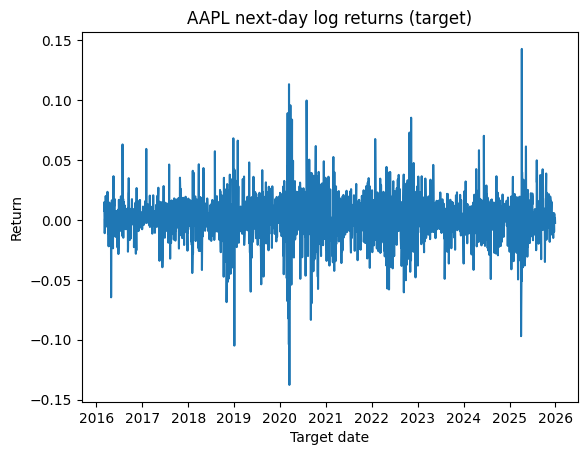

In [9]:
# Load processed data
panel = pd.read_parquet(PROC_DIR / "panel.parquet")

# 1) Check split coverage
print(panel.groupby(["Ticker", "split"]).size().unstack(fill_value=0))

# 2) Target must be later than feature date
bad_rows = (panel["target_date"] <= panel["Date"]).sum()
print("Rows where target_date <= Date (should be 0):", bad_rows)

# 3) Plot one ticker target series
one = panel[panel["Ticker"] == "AAPL"].sort_values("target_date")

plt.figure()
plt.plot(one["target_date"], one["target_ret"])
plt.title("AAPL next-day log returns (target)")
plt.xlabel("Target date")
plt.ylabel("Return")
plt.show()

In [10]:
import pandas as pd
from pathlib import Path

def find_existing_path(candidates):
    for p in candidates:
        p = Path(p)
        if p.exists():
            return p
    raise FileNotFoundError("Could not find file in candidates:\n" + "\n".join(map(str, candidates)))

# Locate the panel file (works whether you used stock_project/ or data/)
panel_path = find_existing_path([
    "stock_project/data/processed/panel.parquet",
    "data/processed/panel.parquet"
])

# Set output dirs near the panel file
project_root = panel_path.parents[2]  # .../data/processed/panel.parquet -> project_root = ...
tables_dir = project_root / "reports" / "tables"
tables_dir.mkdir(parents=True, exist_ok=True)

panel = pd.read_parquet(panel_path)

FEATURE_DICT = {
    # Identifiers
    "Date": "Feature date t (information up to end of day t).",
    "Ticker": "Asset identifier (stock symbol).",
    "split": "Train/val/test split label based on target_date.",

    # Targets and returns
    "ret": "Log return on date t: log(P_t) - log(P_{t-1}).",
    "target_ret": "Next-day log return to predict: log(P_{t+1}) - log(P_t).",
    "target_date": "Date corresponding to target_ret (t+1).",

    # Stock lags
    "ret_lag1": "Stock return at t-1.",
    "ret_lag2": "Stock return at t-2.",
    "ret_lag3": "Stock return at t-3.",
    "ret_lag5": "Stock return at t-5.",
    "ret_lag10": "Stock return at t-10.",

    # Rolling vol
    "ret_vol5": "Rolling std of returns over last 5 days ending at t.",
    "ret_vol10": "Rolling std of returns over last 10 days ending at t.",
    "ret_vol20": "Rolling std of returns over last 20 days ending at t.",

    # Market/VIX (lagged)
    "mkt_ret_lag1": "SPY market log return at t-1.",
    "vix_level_lag1": "VIX level (close) at t-1.",
    "vix_ret_lag1": "VIX log return at t-1.",

    # FRED levels (lagged)
    "DFF_lag1": "Effective Fed Funds Rate at t-1 (forward-filled to trading days).",
    "DGS10_lag1": "10-year Treasury yield at t-1 (forward-filled).",
    "SP500_lag1": "S&P500 index level at t-1 (from FRED, forward-filled).",

    # FRED transforms (lagged)
    "sp500_ret_lag1": "Log return of FRED SP500 level at t-1.",
    "DFF_diff_lag1": "Daily change in DFF at t-1.",
    "DGS10_diff_lag1": "Daily change in DGS10 at t-1.",
}

# Build a clean table in the same order as your panel columns
rows = []
for col in panel.columns:
    rows.append({
        "feature_name": col,
        "role": ("target" if col == "target_ret"
                 else "identifier" if col in ["Date","Ticker","split","target_date"]
                 else "feature"),
        "definition": FEATURE_DICT.get(col, "No definition found yet (add to FEATURE_DICT)."),
    })

feature_table = pd.DataFrame(rows)

# Show missing definitions (if any)
missing = feature_table[feature_table["definition"].str.startswith("No definition")]
print("Columns missing a definition:", list(missing["feature_name"]))

# Save for paper / appendix
out_path = tables_dir / "feature_dictionary.csv"
feature_table.to_csv(out_path, index=False)

print("Saved feature dictionary to:", out_path.resolve())
feature_table

Columns missing a definition: []
Saved feature dictionary to: /notebooks/stock_project/stock_project/reports/tables/feature_dictionary.csv


,feature_name,role,definition
0,Date,identifier,Feature date t (information up to end of day t).
1,Ticker,identifier,Asset identifier (stock symbol).
2,ret,feature,Log return on date t: log(P_t) - log(P_{t-1}).
3,target_ret,target,Next-day log return to predict: log(P_{t+1}) -...
4,target_date,identifier,Date corresponding to target_ret (t+1).
5,mkt_ret_lag1,feature,SPY market log return at t-1.
6,vix_level_lag1,feature,VIX level (close) at t-1.
7,vix_ret_lag1,feature,VIX log return at t-1.
8,DFF_lag1,feature,Effective Fed Funds Rate at t-1 (forward-fille...
9,DGS10_lag1,feature,10-year Treasury yield at t-1 (forward-filled).


### KEY EDA PLOTS

## Summary stats table per ticker

In [11]:
import numpy as np
import pandas as pd

panel = pd.read_parquet(panel_path).copy()

def stats(x):
    return pd.Series({
        "mean": x.mean(),
        "std": x.std(),
        "ann_vol": x.std() * np.sqrt(252),
        "skew": x.skew(),
        "kurtosis": x.kurtosis(),  # Fisher (normal ~ 0)
        "p01": x.quantile(0.01),
        "p05": x.quantile(0.05),
        "p95": x.quantile(0.95),
        "p99": x.quantile(0.99),
    })

summary = (
    panel.groupby("Ticker")["target_ret"]
    .apply(stats)
    .reset_index()
)

out = tables_dir / "return_summary_stats_by_ticker.csv"
summary.to_csv(out, index=False)
print("Saved:", out.resolve())
summary

Saved: /notebooks/stock_project/stock_project/reports/tables/return_summary_stats_by_ticker.csv


,Ticker,level_1,target_ret
0,AAPL,mean,0.001004
1,AAPL,std,0.018212
2,AAPL,ann_vol,0.289113
3,AAPL,skew,-0.081866
4,AAPL,kurtosis,6.876197
...,...,...,...
67,TSLA,kurtosis,4.250884
68,TSLA,p01,-0.099016
69,TSLA,p05,-0.054889
70,TSLA,p95,0.058806


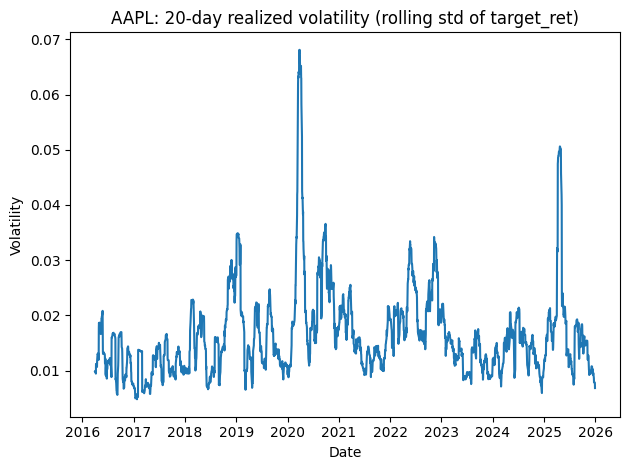

Saved: /notebooks/stock_project/stock_project/reports/figures/AAPL_rolling_vol20.png


In [12]:
import matplotlib.pyplot as plt

ticker = "AAPL"
df = panel[panel["Ticker"] == ticker].sort_values("target_date").copy()

# realized vol proxy (rolling std of next-day return)
df["realized_vol20"] = df["target_ret"].rolling(20).std()

plt.figure()
plt.plot(df["target_date"], df["realized_vol20"])
plt.title(f"{ticker}: 20-day realized volatility (rolling std of target_ret)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.tight_layout()

fig_path = (project_root / "reports" / "figures")
fig_path.mkdir(parents=True, exist_ok=True)
out = fig_path / f"{ticker}_rolling_vol20.png"
plt.savefig(out, dpi=200)
plt.show()

print("Saved:", out.resolve())

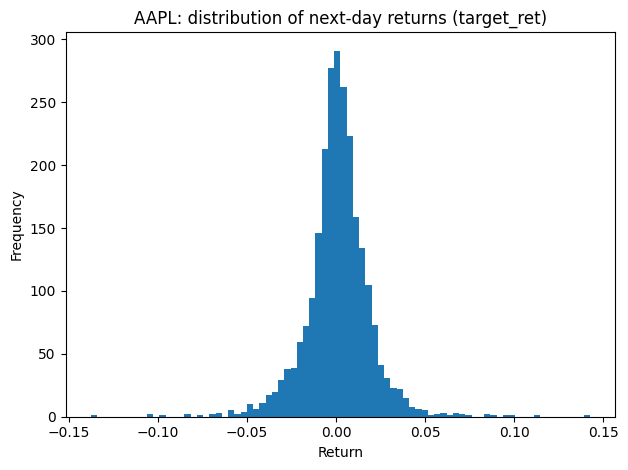

Saved: /notebooks/stock_project/stock_project/reports/figures/AAPL_return_hist.png


In [13]:
ticker = "AAPL"
df = panel[panel["Ticker"] == ticker].copy()

plt.figure()
plt.hist(df["target_ret"], bins=80)
plt.title(f"{ticker}: distribution of next-day returns (target_ret)")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.tight_layout()

out = fig_path / f"{ticker}_return_hist.png"
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out.resolve())

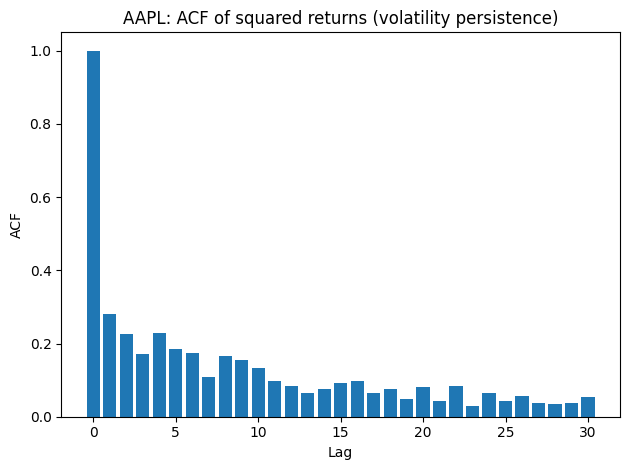

Saved: /notebooks/stock_project/stock_project/reports/figures/AAPL_acf_squared_returns.png


In [14]:
import numpy as np
import matplotlib.pyplot as plt

def simple_acf(x, nlags=30):
    x = np.asarray(x)
    x = x - x.mean()
    denom = np.dot(x, x)
    acf_vals = [1.0]
    for lag in range(1, nlags + 1):
        acf_vals.append(np.dot(x[lag:], x[:-lag]) / denom)
    return np.array(acf_vals)

ticker = "AAPL"
x = panel.loc[panel["Ticker"] == ticker, "target_ret"].dropna().to_numpy()
acf_sq = simple_acf(x**2, nlags=30)

plt.figure()
plt.bar(np.arange(len(acf_sq)), acf_sq)
plt.title(f"{ticker}: ACF of squared returns (volatility persistence)")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.tight_layout()

out = fig_path / f"{ticker}_acf_squared_returns.png"
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out.resolve())

## Feature Engineering :) - GARCH volatility forecasts

### Why GARCH and what are we forecasting?

Daily returns are not i.i.d. in practice. A very common pattern is **volatility clustering**:

- calm periods tend to be followed by calm periods  
- volatile periods tend to be followed by volatile periods  

GARCH models do not mainly “predict the price direction.”  
They model **time-varying uncertainty**, i.e., the conditional variance of returns.

Let daily log return be:

$$
r_t = \log(P_t) - \log(P_{t-1})
$$

A standard volatility model decomposes returns as:

$$
r_t = \mu + \epsilon_t
$$

$$
\epsilon_t = \sigma_t z_t, \quad z_t \sim \text{i.i.d. } (0,1)
$$

So:

- $\sigma_t$ is the conditional volatility at time $t$
- the key task is to model how $\sigma_t$ evolves over time


#### GARCH(1,1)

$$
\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2
$$

**Intuition:**

- If yesterday’s shock $\epsilon_{t-1}$ was large, tomorrow’s variance increases  
- Variance is persistent via $\beta \sigma_{t-1}^2$

Typical constraints:

$$
\omega > 0, \quad \alpha \ge 0, \quad \beta \ge 0, \quad \alpha + \beta < 1
$$


#### GJR-GARCH(1,1) (leverage / asymmetry)

Negative returns often increase volatility more than positive returns of the same size.

$$
\sigma_t^2 =
\omega
+ \alpha \epsilon_{t-1}^2
+ \gamma \mathbf{1}(\epsilon_{t-1} < 0)\epsilon_{t-1}^2
+ \beta \sigma_{t-1}^2
$$


#### EGARCH(1,1)

Uses log-variance so positivity is automatic:

$$
\log(\sigma_t^2)
=
\omega
+ \alpha (|z_{t-1}| - E|z|)
+ \gamma z_{t-1}
+ \beta \log(\sigma_{t-1}^2)
$$


For each ticker:

1. Fit each volatility model **using only the training window** (no test leakage).  
2. Produce **1-step-ahead variance forecasts**:

$$
\widehat{\sigma^2_{t+1|t}}
$$

3. Merge these forecasts into the panel as features so we can build:
   - pure econometric volatility benchmarks
   - hybrids like GARCH–GRU/LSTM

We will evaluate volatility forecasts using a standard loss (QLIKE):

$$
L_t
=
\log(\hat{\sigma}^2_{t+1|t})
+
\frac{r_{t+1}^2}{\hat{\sigma}^2_{t+1|t}}
$$

Lower is better.

In [15]:
from pathlib import Path
import shutil

# One project root folder
PROJECT_DIR = Path("stock_project")

RAW_DIR  = PROJECT_DIR / "data" / "raw"
PROC_DIR = PROJECT_DIR / "data" / "processed"
FIG_DIR  = PROJECT_DIR / "reports" / "figures"
TAB_DIR  = PROJECT_DIR / "reports" / "tables"

for d in [RAW_DIR, PROC_DIR, FIG_DIR, TAB_DIR]:
    d.mkdir(parents=True, exist_ok=True)

OLD_RAW_DIR = Path("data/raw")
OLD_PROC_DIR = Path("data/processed")

to_copy = [
    (OLD_RAW_DIR / "prices_adj_close.csv", RAW_DIR / "prices_adj_close.csv"),
    (OLD_RAW_DIR / "fred_macro.csv",       RAW_DIR / "fred_macro.csv"),
    (OLD_PROC_DIR / "panel.parquet",       PROC_DIR / "panel.parquet"),
    (OLD_PROC_DIR / "audit_summary.csv",   PROC_DIR / "audit_summary.csv"),
]

for src, dst in to_copy:
    if src.exists() and not dst.exists():
        shutil.copy2(src, dst)
        print(f"Copied {src} -> {dst}")

print("Project root:", PROJECT_DIR.resolve())
print("RAW_DIR:", RAW_DIR)
print("PROC_DIR:", PROC_DIR)
print("TAB_DIR:", TAB_DIR)

Project root: /notebooks/stock_project/stock_project
RAW_DIR: stock_project/data/raw
PROC_DIR: stock_project/data/processed
TAB_DIR: stock_project/reports/tables


In [16]:
import sys, subprocess

try:
    from arch import arch_model
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "arch"])
    from arch import arch_model

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

print("arch_model imported successfully")

arch_model imported successfully


In [17]:
import json

tickers = panel["Ticker"].unique()

SCALE = 100.0  # scale returns to percent for numerical stability

def last_obs_exclusive_loc(index: pd.DatetimeIndex, last_date_inclusive: pd.Timestamp) -> int:
    """
    arch.fit(last_obs=...) uses python slicing rules (exclusive).
    We convert an inclusive date cutoff into an exclusive integer location.
    """
    in_sample = index[index <= last_date_inclusive]
    if len(in_sample) == 0:
        raise ValueError("No observations <= last_date_inclusive. Check your cutoff date.")
    last_date = in_sample.max()
    return index.get_loc(last_date) + 1  # exclusive location

MODEL_SPECS = {
    # Standard symmetric GARCH(1,1)
    "garch11_t":  dict(mean="Zero", vol="GARCH",  p=1, o=0, q=1, dist="t"),
    # GJR-GARCH(1,1) (asymmetry / leverage)
    "gjr11_t":    dict(mean="Zero", vol="GARCH",  p=1, o=1, q=1, dist="t"),
    # EGARCH(1,1) (log variance dynamics)
    "egarch11_t": dict(mean="Zero", vol="EGARCH", p=1, o=1, q=1, dist="t"),
}

def fit_and_forecast_var1(y_pct: pd.Series, spec: dict, last_obs_excl: int) -> tuple:
    """
    Fit model on y_pct[:last_obs_excl], then produce 1-step-ahead variance forecasts var_{t+1|t}
    aligned to y_pct.index (origin alignment).
    """
    am = arch_model(y_pct, rescale=False, **spec)
    res = am.fit(disp="off", update_freq=0, last_obs=last_obs_excl)
    fc = res.forecast(horizon=1, start=0, reindex=True, align="origin")
    var1 = fc.variance["h.1"]  # time-t forecast for time t+1
    return res, var1

garch_feature_frames = []
fit_rows = []

for ticker in tickers:
    # One return series per ticker (log returns)
    s = (
        panel.loc[panel["Ticker"] == ticker, ["Date", "ret"]]
        .drop_duplicates(subset=["Date"])
        .set_index("Date")["ret"]
        .sort_index()
    )

    # Scale to percent
    y_pct = SCALE * s

    # Fit only up to end of TRAIN (no leakage)
    last_obs_excl = last_obs_exclusive_loc(y_pct.index,TRAIN_END )

    for model_name, spec in MODEL_SPECS.items():
        try:
            res, var1_pct2 = fit_and_forecast_var1(y_pct, spec, last_obs_excl)

            # Convert variance back to return-units (not percent^2)
            var1 = (var1_pct2 / (SCALE**2)).rename(f"{model_name}_var1")
            sigma1 = np.sqrt(var1).rename(f"{model_name}_sigma1")

            df_feat = pd.concat([var1, sigma1], axis=1).reset_index().rename(columns={"index": "Date"})
            df_feat["Ticker"] = ticker
            garch_feature_frames.append(df_feat)

            fit_rows.append({
                "Ticker": ticker,
                "model": model_name,
                "nobs_total": len(y_pct),
                "nobs_fit": int(last_obs_excl),
                "loglik": float(res.loglikelihood),
                "aic": float(res.aic),
                "bic": float(res.bic),
                "params_json": json.dumps(res.params.to_dict()),
            })

            print(f"[OK] {ticker:5s} {model_name:10s} | fit_n={last_obs_excl} | AIC={res.aic:.2f}")
        except Exception as e:
            print(f"[FAIL] {ticker:5s} {model_name:10s} -> {repr(e)}")

garch_features = pd.concat(garch_feature_frames, ignore_index=True)
fit_summary = pd.DataFrame(fit_rows)

garch_path = PROC_DIR / "garch_features_trainfit.parquet"
fit_path = TAB_DIR / "garch_fit_summary_trainfit.csv"

garch_features.to_parquet(garch_path, index=False)
fit_summary.to_csv(fit_path, index=False)

print("Saved:", garch_path)
print("Saved:", fit_path)
fit_summary.head()

[OK] AAPL  garch11_t  | fit_n=966 | AIC=3282.36
[OK] AAPL  gjr11_t    | fit_n=966 | AIC=3253.30
[OK] AAPL  egarch11_t | fit_n=966 | AIC=3246.76
[OK] AMZN  garch11_t  | fit_n=966 | AIC=3396.33
[OK] AMZN  gjr11_t    | fit_n=966 | AIC=3379.17
[OK] AMZN  egarch11_t | fit_n=966 | AIC=3380.40
[OK] GOOGL garch11_t  | fit_n=966 | AIC=3118.79
[OK] GOOGL gjr11_t    | fit_n=966 | AIC=3111.52
[OK] GOOGL egarch11_t | fit_n=966 | AIC=3109.29
[OK] META  garch11_t  | fit_n=966 | AIC=3459.70
[OK] META  gjr11_t    | fit_n=966 | AIC=3444.97
[OK] META  egarch11_t | fit_n=966 | AIC=3428.65
[OK] MSFT  garch11_t  | fit_n=966 | AIC=3064.16
[OK] MSFT  gjr11_t    | fit_n=966 | AIC=3037.97
[OK] MSFT  egarch11_t | fit_n=966 | AIC=3031.49
[OK] NVDA  garch11_t  | fit_n=966 | AIC=4380.28
[OK] NVDA  gjr11_t    | fit_n=966 | AIC=4363.42
[OK] NVDA  egarch11_t | fit_n=966 | AIC=4356.84
[OK] ORCL  garch11_t  | fit_n=966 | AIC=2875.70
[OK] ORCL  gjr11_t    | fit_n=966 | AIC=2874.72
[OK] ORCL  egarch11_t | fit_n=966 | AIC=

,Ticker,model,nobs_total,nobs_fit,loglik,aic,bic,params_json
0,AAPL,garch11_t,2472,966,-1637.181964,3282.363929,3301.856584,"{""omega"": 0.19974829533880578, ""alpha[1]"": 0.1..."
1,AAPL,gjr11_t,2472,966,-1621.651027,3253.302055,3277.667874,"{""omega"": 0.14403073566879998, ""alpha[1]"": 0.0..."
2,AAPL,egarch11_t,2472,966,-1618.379216,3246.758432,3271.124251,"{""omega"": 0.0758149937463695, ""alpha[1]"": 0.18..."
3,AMZN,garch11_t,2472,966,-1694.162543,3396.325087,3415.817742,"{""omega"": 0.1731464469249476, ""alpha[1]"": 0.17..."
4,AMZN,gjr11_t,2472,966,-1684.584529,3379.169057,3403.534877,"{""omega"": 0.19342467750414297, ""alpha[1]"": 0.0..."


In [18]:
# 1) Merge GARCH features into the panel (keep ALL panel rows)
panel_garch = panel.merge(garch_features, on=["Date", "Ticker"], how="left")

# 2) Identify the GARCH feature columns
sigma_cols = [c for c in panel_garch.columns if c.endswith("_sigma1")]
var_cols   = [c for c in panel_garch.columns if c.endswith("_var1")]

# 3) Check missingness (this is just diagnostics)
missing_rates = panel_garch[sigma_cols + var_cols].isna().mean().sort_values(ascending=False)
print("Missing rates for GARCH columns (NaNs are expected early / where forecasts not available):")
display(missing_rates.head(10))

# 4) Create a flag: does this row have GARCH forecasts available?
# (We use "all var cols present" as the requirement for hybrid experiments)
panel_garch["has_garch"] = panel_garch[var_cols].notna().all(axis=1)

print("Original panel rows:", len(panel_garch))
print("Rows with GARCH available:", int(panel_garch["has_garch"].sum()))
print("Share with GARCH available:", float(panel_garch["has_garch"].mean()))

# 5) Save the full merged dataset 
panel_garch_path = PROC_DIR / "panel_with_garch_trainfit.parquet"
panel_garch.to_parquet(panel_garch_path, index=False)
print("Saved full panel_with_garch:", panel_garch_path)

# Create a model-ready subset for GARCH-hybrid models only
# This keeps only rows where GARCH exists (do NOT use this for non-GARCH models)
panel_garch_hybrid = panel_garch[panel_garch["has_garch"]].copy()

panel_garch_hybrid_path = PROC_DIR / "panel_with_garch_trainfit_hybrid_only.parquet"
panel_garch_hybrid.to_parquet(panel_garch_hybrid_path, index=False)
print("Saved hybrid-only panel:", panel_garch_hybrid_path)

panel_garch.head()

Missing rates for GARCH columns (NaNs are expected early / where forecasts not available):


garch11_t_sigma1     0.666667
gjr11_t_sigma1       0.666667
egarch11_t_sigma1    0.666667
garch11_t_var1       0.666667
gjr11_t_var1         0.666667
egarch11_t_var1      0.666667
dtype: float64

Original panel rows: 59328
Rows with GARCH available: 0
Share with GARCH available: 0.0
Saved full panel_with_garch: stock_project/data/processed/panel_with_garch_trainfit.parquet
Saved hybrid-only panel: stock_project/data/processed/panel_with_garch_trainfit_hybrid_only.parquet


,Date,Ticker,ret,target_ret,target_date,mkt_ret_lag1,vix_level_lag1,vix_ret_lag1,DFF_lag1,DGS10_lag1,...,ret_vol10,ret_vol20,split,garch11_t_var1,garch11_t_sigma1,gjr11_t_var1,gjr11_t_sigma1,egarch11_t_var1,egarch11_t_sigma1,has_garch
0,2016-03-02,AAPL,0.002186,0.007417,2016-03-03,0.023235,17.700001,-0.149296,0.36,1.83,...,0.017303,0.016093,train,0.000134,0.011591,NaN,NaN,NaN,NaN,False
1,2016-03-02,AAPL,0.002186,0.007417,2016-03-03,0.023235,17.700001,-0.149296,0.36,1.83,...,0.017303,0.016093,train,NaN,NaN,0.000134,0.011571,NaN,NaN,False
2,2016-03-02,AAPL,0.002186,0.007417,2016-03-03,0.023235,17.700001,-0.149296,0.36,1.83,...,0.017303,0.016093,train,NaN,NaN,NaN,NaN,0.000128,0.011331,False
3,2016-03-03,AAPL,0.007417,0.014767,2016-03-04,0.004482,17.090000,-0.035071,0.37,1.84,...,0.015536,0.015677,train,0.000134,0.011574,NaN,NaN,NaN,NaN,False
4,2016-03-03,AAPL,0.007417,0.014767,2016-03-04,0.004482,17.090000,-0.035071,0.37,1.84,...,0.015536,0.015677,train,NaN,NaN,0.000127,0.011263,NaN,NaN,False


In [19]:
# Load saved garch features
garch_features = pd.read_parquet(PROC_DIR / "garch_features_trainfit.parquet").copy()

# IMPORTANT:
# garch sigma1/var1 at Date=t forecasts volatility for t+1.
# Our panel label lives at target_date=t+1.
# So shift the GARCH feature date forward by 1 trading day per ticker.

garch_features = garch_features.sort_values(["Ticker", "Date"]).copy()
garch_features["target_date"] = garch_features.groupby("Ticker")["Date"].shift(-1)

# Drop rows where target_date is missing (last date per ticker)
garch_features = garch_features.dropna(subset=["target_date"]).copy()
garch_features["target_date"] = pd.to_datetime(garch_features["target_date"])


In [20]:
# First, load raw garch features
garch_features = pd.read_parquet(PROC_DIR / "garch_features_trainfit.parquet")

# Ensure no duplicates per (Date, Ticker, model)
print("Before pivot shape:", garch_features.shape)

# Pivot from long format to wide format
garch_wide = (
    garch_features
    .pivot_table(
        index=["Date", "Ticker"],
        values=[c for c in garch_features.columns if c.endswith("_var1") or c.endswith("_sigma1")],
        aggfunc="first"
    )
    .reset_index()
)

print("After pivot shape:", garch_wide.shape)

# Merge onto panel (merge on Date, not target_date yet)
panel_garch = panel.merge(garch_wide, on=["Date", "Ticker"], how="left")

sigma_cols = [c for c in panel_garch.columns if c.endswith("_sigma1")]
var_cols   = [c for c in panel_garch.columns if c.endswith("_var1")]

panel_garch["has_garch"] = panel_garch[var_cols].notna().all(axis=1)

print("Rows with GARCH available:", panel_garch["has_garch"].sum())
print("Share with GARCH available:", panel_garch["has_garch"].mean())

panel_garch.head()

Before pivot shape: (59328, 8)
After pivot shape: (19776, 8)
Rows with GARCH available: 19776
Share with GARCH available: 1.0


,Date,Ticker,ret,target_ret,target_date,mkt_ret_lag1,vix_level_lag1,vix_ret_lag1,DFF_lag1,DGS10_lag1,...,ret_vol10,ret_vol20,split,egarch11_t_sigma1,egarch11_t_var1,garch11_t_sigma1,garch11_t_var1,gjr11_t_sigma1,gjr11_t_var1,has_garch
0,2016-03-02,AAPL,0.002186,0.007417,2016-03-03,0.023235,17.700001,-0.149296,0.36,1.83,...,0.017303,0.016093,train,0.011331,0.000128,0.011591,0.000134,0.011571,0.000134,True
1,2016-03-03,AAPL,0.007417,0.014767,2016-03-04,0.004482,17.090000,-0.035071,0.37,1.84,...,0.015536,0.015677,train,0.010909,0.000119,0.011574,0.000134,0.011263,0.000127,True
2,2016-03-04,AAPL,0.014767,-0.011128,2016-03-07,0.003912,16.700001,-0.023085,0.37,1.83,...,0.015547,0.015865,train,0.010600,0.000112,0.012630,0.000160,0.011058,0.000122,True
3,2016-03-07,AAPL,-0.011128,-0.008280,2016-03-08,0.003249,16.860001,0.009535,0.36,1.88,...,0.016539,0.014614,train,0.012257,0.000150,0.012830,0.000165,0.012173,0.000148,True
4,2016-03-08,AAPL,-0.008280,0.000890,2016-03-09,0.000798,17.350000,0.028649,0.36,1.91,...,0.014298,0.014779,train,0.013145,0.000173,0.012643,0.000160,0.012481,0.000156,True


# Model Building and Evaluation (Publication-Grade Protocol)

This section trains baseline forecasting models for next-day log returns (`target_ret`) using a strictly time-ordered split:

- **train**: used to fit model parameters
- **val**: used for hyperparameter selection 
- **test**: used once for final performance reporting

Key principles:
1. **No leakage**: features are constructed from information available at or before `Date=t`, while the label is `target_ret` at `target_date=t+1`.
2. **Consistent evaluation**: every model is evaluated with the same metrics and on the same splits.
3. **Reproducibility**:
   - Save row-level predictions (`y_true`, `y_pred`) for train/val/test.
   - Save summary metrics to a single table that accumulates results across models.
   - Save interpretability outputs (linear coefficients, tree feature importances).

Main metrics (point forecasts of returns):
- MAE and RMSE (reported in basis points for readability)
- Pearson correlation between predictions and realized returns (information coefficient)
- Directional accuracy: fraction of days where sign(prediction) matches sign(realized)
- Out-of-sample R² relative to a simple baseline (computed later once a baseline is established)


In [21]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# -----------------------
# Paths (edit if needed)
# -----------------------
PROJECT_ROOT = Path("stock_project")
PROC_DIR = PROJECT_ROOT / "data" / "processed"
REPORTS_DIR = PROJECT_ROOT / "reports"
PRED_DIR = REPORTS_DIR / "predictions"
TAB_DIR  = REPORTS_DIR / "tables"
FIG_DIR  = REPORTS_DIR / "figures"

for d in [PROC_DIR, PRED_DIR, TAB_DIR, FIG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# -----------------------
# Load base panel + GARCH features (rebuild clean merge each time)
# -----------------------
panel_path = PROC_DIR / "panel.parquet"
garch_path = PROC_DIR / "garch_features_trainfit.parquet"

panel = pd.read_parquet(panel_path).copy()
garch_features = pd.read_parquet(garch_path).copy()

panel["Date"] = pd.to_datetime(panel["Date"])
panel["target_date"] = pd.to_datetime(panel["target_date"])

# Pivot GARCH to wide (one row per Date+Ticker, all models as columns)
value_cols = [c for c in garch_features.columns if c.endswith("_var1") or c.endswith("_sigma1")]

garch_wide = (
    garch_features
    .pivot_table(index=["Date", "Ticker"], values=value_cols, aggfunc="first")
    .reset_index()
)

# Merge
panel_garch = panel.merge(garch_wide, on=["Date", "Ticker"], how="left")

# Sanity checks
assert panel_garch.duplicated(subset=["Date", "Ticker"]).sum() == 0, "Duplicate (Date,Ticker) rows found."
assert (panel_garch["target_date"] > panel_garch["Date"]).all(), "Leakage check failed: target_date must be after Date."

# has_garch indicator
sigma_cols = [c for c in panel_garch.columns if c.endswith("_sigma1")]
var_cols   = [c for c in panel_garch.columns if c.endswith("_var1")]
panel_garch["has_garch"] = panel_garch[var_cols].notna().all(axis=1)

print("Panel rows:", len(panel_garch))
print("GARCH coverage (share with all GARCH models available):", float(panel_garch["has_garch"].mean()))

# -----------------------
# Train/Val/Test splits
# -----------------------
train_df = panel_garch[panel_garch["split"] == "train"].copy()
val_df   = panel_garch[panel_garch["split"] == "val"].copy()
test_df  = panel_garch[panel_garch["split"] == "test"].copy()

TARGET_COL = "target_ret"
CAT_COLS = ["Ticker"]

# -----------------------
# Feature sets
# -----------------------
NON_FEATURE_COLS = {"Date", "target_date", "split", TARGET_COL, "has_garch"}

all_candidate_features = [c for c in panel_garch.columns if c not in NON_FEATURE_COLS]
num_features_all = [c for c in all_candidate_features if c not in CAT_COLS]

# Base features exclude GARCH columns
garch_feature_cols = sigma_cols + var_cols
num_features_base = [c for c in num_features_all if c not in garch_feature_cols]

# A recommended GARCH feature set: use sigma only (variance is sigma^2 and redundant)
num_features_plus_garch_sigma = num_features_base + sigma_cols

print("Num features (base):", len(num_features_base))
print("Num features (+GARCH sigma):", len(num_features_plus_garch_sigma))

# -----------------------
# Metrics + saving helpers
# -----------------------
BPS = 10_000  # basis points (1.0 return = 10,000 bps)

def safe_corr(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    if len(y_true) < 2:
        return np.nan
    if np.std(y_pred) == 0 or np.std(y_true) == 0:
        return np.nan
    return float(np.corrcoef(y_true, y_pred)[0, 1])

def regression_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))

    mae_bps = mae * BPS
    rmse_bps = rmse * BPS

    directional_acc = float(np.mean(np.sign(y_true) == np.sign(y_pred)))
    corr = safe_corr(y_true, y_pred)

    return {
        "MAE": mae,
        "RMSE": rmse,
        "MSE": mse,
        "MAE_bps": mae_bps,
        "RMSE_bps": rmse_bps,
        "DirectionalAcc": directional_acc,
        "Corr": corr,
    }

def make_pred_frame(df_part: pd.DataFrame, y_pred: np.ndarray, model_name: str) -> pd.DataFrame:
    out = df_part[["Date", "target_date", "Ticker", "split"]].copy()
    out["model"] = model_name
    out["y_true"] = df_part[TARGET_COL].to_numpy()
    out["y_pred"] = np.asarray(y_pred)
    out["residual"] = out["y_true"] - out["y_pred"]
    return out

def evaluate_predictions(pred_df: pd.DataFrame, model_name: str, baseline_mse_by_split: dict | None = None) -> pd.DataFrame:
    rows = []
    for split in ["train", "val", "test"]:
        d = pred_df[pred_df["split"] == split]
        m = regression_metrics(d["y_true"].to_numpy(), d["y_pred"].to_numpy())
        m["model"] = model_name
        m["split"] = split
        m["n"] = len(d)

        if baseline_mse_by_split is not None and split in baseline_mse_by_split:
            m["OOS_R2_vs_baseline"] = 1.0 - (m["MSE"] / baseline_mse_by_split[split])
        else:
            m["OOS_R2_vs_baseline"] = np.nan

        rows.append(m)

    return pd.DataFrame(rows)

def save_predictions_and_metrics(pred_df: pd.DataFrame, metrics_df: pd.DataFrame, model_name: str) -> None:
    pred_path = PRED_DIR / f"{model_name}.parquet"
    pred_df.to_parquet(pred_path, index=False)
    print("Saved predictions:", pred_path)

    metrics_path = TAB_DIR / "model_metrics.csv"
    if metrics_path.exists():
        old = pd.read_csv(metrics_path)
        old = old[old["model"] != model_name]  # overwrite if re-run
        combined = pd.concat([old, metrics_df], ignore_index=True)
    else:
        combined = metrics_df

    combined.to_csv(metrics_path, index=False)
    print("Updated metrics table:", metrics_path)

# We will set this after we run a baseline model
BASELINE_MSE_BY_SPLIT = None

Panel rows: 19776
GARCH coverage (share with all GARCH models available): 1.0
Num features (base): 18
Num features (+GARCH sigma): 21


## Naive baseline (predict 0 return)

This baseline predicts zero return for every observation.
In return forecasting, this is a strong sanity check because many models struggle to beat it.

We will:
- Generate predictions for train/val/test (all zeros)
- Save row-level predictions for plotting
- Save summary metrics for the paper

In [23]:
MODEL_NAME = "baseline_zero"

pred_train = np.zeros(len(train_df))
pred_val   = np.zeros(len(val_df))
pred_test  = np.zeros(len(test_df))

pred_df = pd.concat([
    make_pred_frame(train_df, pred_train, MODEL_NAME),
    make_pred_frame(val_df,   pred_val,   MODEL_NAME),
    make_pred_frame(test_df,  pred_test,  MODEL_NAME),
], ignore_index=True)

metrics_df = evaluate_predictions(pred_df, MODEL_NAME, baseline_mse_by_split=None)
display(metrics_df)

save_predictions_and_metrics(pred_df, metrics_df, MODEL_NAME)

,MAE,RMSE,MSE,MAE_bps,RMSE_bps,DirectionalAcc,Corr,model,split,n,OOS_R2_vs_baseline
0,0.012403,0.019210,0.000369,124.033400,192.095383,0.004534,NaN,baseline_zero,train,7720,NaN
1,0.019788,0.029259,0.000856,197.881323,292.585804,0.001157,NaN,baseline_zero,val,6048,NaN
2,0.016531,0.024833,0.000617,165.308309,248.334237,0.001831,NaN,baseline_zero,test,6008,NaN


Saved predictions: stock_project/reports/predictions/baseline_zero.parquet
Updated metrics table: stock_project/reports/tables/model_metrics.csv


## Historical mean baseline (per ticker)

This baseline predicts the average next-day return for each ticker, estimated using training data only.

For each ticker:
- Compute mean(target_ret) over the training split
- Predict that constant mean for all future days

This baseline is a standard reference point for computing **out-of-sample R²**:
OOS_R² = 1 - MSE_model / MSE_baseline

In [24]:
MODEL_NAME = "baseline_ticker_mean"

# Mean target return per ticker from TRAIN only
ticker_mean = train_df.groupby("Ticker")[TARGET_COL].mean()

def predict_ticker_mean(df_part: pd.DataFrame) -> np.ndarray:
    return df_part["Ticker"].map(ticker_mean).to_numpy()

pred_df = pd.concat([
    make_pred_frame(train_df, predict_ticker_mean(train_df), MODEL_NAME),
    make_pred_frame(val_df,   predict_ticker_mean(val_df),   MODEL_NAME),
    make_pred_frame(test_df,  predict_ticker_mean(test_df),  MODEL_NAME),
], ignore_index=True)

metrics_df = evaluate_predictions(pred_df, MODEL_NAME, baseline_mse_by_split=None)
display(metrics_df)

# Save baseline MSE for OOS_R2 comparisons later
BASELINE_MSE_BY_SPLIT = metrics_df.set_index("split")["MSE"].to_dict()
print("Baseline MSE by split:", BASELINE_MSE_BY_SPLIT)

save_predictions_and_metrics(pred_df, metrics_df, MODEL_NAME)

,MAE,RMSE,MSE,MAE_bps,RMSE_bps,DirectionalAcc,Corr,model,split,n,OOS_R2_vs_baseline
0,0.012353,0.019176,0.000368,123.532709,191.764910,0.538860,0.025203,baseline_ticker_mean,train,7720,NaN
1,0.019762,0.029256,0.000856,197.622158,292.562465,0.522156,0.007244,baseline_ticker_mean,val,6048,NaN
2,0.016471,0.024781,0.000614,164.712567,247.811795,0.542610,0.015846,baseline_ticker_mean,test,6008,NaN


Baseline MSE by split: {'train': 0.00036773780883320856, 'val': 0.0008559279607838029, 'test': 0.0006141068576856303}
Saved predictions: stock_project/reports/predictions/baseline_ticker_mean.parquet
Updated metrics table: stock_project/reports/tables/model_metrics.csv


## AR(1)-style baseline per ticker

A simple autoregressive baseline predicts next-day return using today's return:
target_ret(t+1) ≈ a + b * ret(t)

We fit (a, b) per ticker using training data only, then predict on val/test.
This is essentially an AR(1) model aligned to our supervised next-day target.

In [25]:
MODEL_NAME = "baseline_ar1_per_ticker"

# Fit per ticker: target_ret = a + b * ret
coeffs = {}
for ticker, df_t in train_df.groupby("Ticker"):
    X = df_t[["ret"]].to_numpy()
    y = df_t[TARGET_COL].to_numpy()

    lr = LinearRegression()
    lr.fit(X, y)
    coeffs[ticker] = (float(lr.intercept_), float(lr.coef_[0]))

coef_df = pd.DataFrame([
    {"Ticker": t, "intercept": a, "beta_ret": b}
    for t, (a, b) in coeffs.items()
]).sort_values("Ticker")

coef_path = TAB_DIR / f"{MODEL_NAME}_coefficients.csv"
coef_df.to_csv(coef_path, index=False)
print("Saved AR(1) coefficients:", coef_path)
display(coef_df)

def predict_ar1(df_part: pd.DataFrame) -> np.ndarray:
    preds = []
    for _, row in df_part.iterrows():
        a, b = coeffs[row["Ticker"]]
        preds.append(a + b * row["ret"])
    return np.array(preds)

pred_df = pd.concat([
    make_pred_frame(train_df, predict_ar1(train_df), MODEL_NAME),
    make_pred_frame(val_df,   predict_ar1(val_df),   MODEL_NAME),
    make_pred_frame(test_df,  predict_ar1(test_df),  MODEL_NAME),
], ignore_index=True)

metrics_df = evaluate_predictions(pred_df, MODEL_NAME, baseline_mse_by_split=BASELINE_MSE_BY_SPLIT)
display(metrics_df)

save_predictions_and_metrics(pred_df, metrics_df, MODEL_NAME)

Saved AR(1) coefficients: stock_project/reports/tables/baseline_ar1_per_ticker_coefficients.csv


,Ticker,intercept,beta_ret
0,AAPL,0.001138,0.030231
1,AMZN,0.001200,0.000117
2,GOOGL,0.000611,0.007827
3,META,0.000664,-0.027235
4,MSFT,0.001373,-0.136404
5,NVDA,0.002145,-0.043986
6,ORCL,0.000416,-0.007828
7,TSLA,0.000837,-0.012256


,MAE,RMSE,MSE,MAE_bps,RMSE_bps,DirectionalAcc,Corr,model,split,n,OOS_R2_vs_baseline
0,0.012332,0.019159,0.000367,123.317605,191.587998,0.538990,0.049782,baseline_ar1_per_ticker,train,7720,0.001844
1,0.019747,0.029192,0.000852,197.468274,291.924300,0.524471,0.069865,baseline_ar1_per_ticker,val,6048,0.004358
2,0.016474,0.024777,0.000614,164.735998,247.766638,0.542111,0.028373,baseline_ar1_per_ticker,test,6008,0.000364


Saved predictions: stock_project/reports/predictions/baseline_ar1_per_ticker.parquet
Updated metrics table: stock_project/reports/tables/model_metrics.csv


## Linear Regression (base features)

This model learns a linear mapping from engineered features to next-day returns.

We use a pooled model across all tickers, including:
- numeric features (standardized using training only)
- ticker identity as a categorical feature (one-hot encoded)

Linear regression is:
- fast
- interpretable (coefficients)
- a strong baseline for publications

We train on train split and evaluate on val/test.

In [26]:
MODEL_NAME = "linear_regression_base"

NUM_FEATURES = num_features_base  # base set (no GARCH)

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), NUM_FEATURES),
        ("cat", OneHotEncoder(handle_unknown="ignore"), ["Ticker"]),
    ],
    remainder="drop"
)

pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", LinearRegression()),
])

pipe.fit(train_df[NUM_FEATURES + ["Ticker"]], train_df[TARGET_COL])

pred_df = pd.concat([
    make_pred_frame(train_df, pipe.predict(train_df[NUM_FEATURES + ["Ticker"]]), MODEL_NAME),
    make_pred_frame(val_df,   pipe.predict(val_df[NUM_FEATURES + ["Ticker"]]),   MODEL_NAME),
    make_pred_frame(test_df,  pipe.predict(test_df[NUM_FEATURES + ["Ticker"]]),  MODEL_NAME),
], ignore_index=True)

metrics_df = evaluate_predictions(pred_df, MODEL_NAME, baseline_mse_by_split=BASELINE_MSE_BY_SPLIT)
display(metrics_df)

# Save coefficients (interpretability)
feat_names = pipe.named_steps["preprocess"].get_feature_names_out()
coefs = pipe.named_steps["model"].coef_
coef_df = pd.DataFrame({"feature": feat_names, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)

coef_path = TAB_DIR / f"{MODEL_NAME}_coefficients.csv"
coef_df.to_csv(coef_path, index=False)
print("Saved coefficients:", coef_path)
display(coef_df.head(20))

save_predictions_and_metrics(pred_df, metrics_df, MODEL_NAME)

,MAE,RMSE,MSE,MAE_bps,RMSE_bps,DirectionalAcc,Corr,model,split,n,OOS_R2_vs_baseline
0,0.012331,0.019080,0.000364,123.308759,190.800827,0.537565,0.103239,linear_regression_base,train,7720,0.010030
1,0.020034,0.029684,0.000881,200.340943,296.841625,0.507937,-0.039745,linear_regression_base,val,6048,-0.029467
2,0.017491,0.025511,0.000651,174.913033,255.108866,0.462383,0.053137,linear_regression_base,test,6008,-0.059759


Saved coefficients: stock_project/reports/tables/linear_regression_base_coefficients.csv


,feature,coef,abs_coef
7,num__sp500_ret_lag1,-0.009651,0.009651
1,num__mkt_ret_lag1,0.007959,0.007959
16,num__ret_vol10,0.001437,0.001437
3,num__vix_ret_lag1,-0.001056,0.001056
8,num__DFF_diff_lag1,0.000927,0.000927
5,num__DGS10_lag1,-0.000892,0.000892
23,cat__Ticker_NVDA,0.000752,0.000752
15,num__ret_vol5,-0.000663,0.000663
25,cat__Ticker_TSLA,-0.000634,0.000634
14,num__ret_lag10,-0.000632,0.000632


Saved predictions: stock_project/reports/predictions/linear_regression_base.parquet
Updated metrics table: stock_project/reports/tables/model_metrics.csv


## Ridge Regression (base features)

Ridge regression is a regularized linear model.
It is often preferred in finance because features can be correlated, and ridge stabilizes coefficients.

We tune the regularization strength alpha using validation RMSE.
Then we fit the final ridge model on training data with the chosen alpha and evaluate on val/test.

We also save coefficients for interpretability.

In [28]:
MODEL_NAME = "ridge_regression_base"

NUM_FEATURES = num_features_base  # base set (no GARCH)

alphas = np.logspace(-4, 3, 12)  # 1e-4 ... 1e3
tuning_rows = []

for a in alphas:
    preprocess = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), NUM_FEATURES),
            ("cat", OneHotEncoder(handle_unknown="ignore"), ["Ticker"]),
        ],
        remainder="drop"
    )

    pipe = Pipeline([
        ("preprocess", preprocess),
        ("model", Ridge(alpha=float(a), random_state=42)),
    ])

    pipe.fit(train_df[NUM_FEATURES + ["Ticker"]], train_df[TARGET_COL])
    val_pred = pipe.predict(val_df[NUM_FEATURES + ["Ticker"]])
    m = regression_metrics(val_df[TARGET_COL].to_numpy(), val_pred)

    tuning_rows.append({"alpha": float(a), "val_RMSE_bps": m["RMSE_bps"], "val_MAE_bps": m["MAE_bps"]})

tuning_df = pd.DataFrame(tuning_rows).sort_values("val_RMSE_bps")
tune_path = TAB_DIR / f"{MODEL_NAME}_tuning.csv"
tuning_df.to_csv(tune_path, index=False)
print("Saved tuning table:", tune_path)
display(tuning_df.head(10))

best_alpha = float(tuning_df.iloc[0]["alpha"])
print("Chosen alpha:", best_alpha)

# Fit final ridge on TRAIN only (clean out-of-sample val/test evaluation)
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), NUM_FEATURES),
        ("cat", OneHotEncoder(handle_unknown="ignore"), ["Ticker"]),
    ],
    remainder="drop"
)

pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", Ridge(alpha=best_alpha, random_state=42)),
])

pipe.fit(train_df[NUM_FEATURES + ["Ticker"]], train_df[TARGET_COL])

pred_df = pd.concat([
    make_pred_frame(train_df, pipe.predict(train_df[NUM_FEATURES + ["Ticker"]]), MODEL_NAME),
    make_pred_frame(val_df,   pipe.predict(val_df[NUM_FEATURES + ["Ticker"]]),   MODEL_NAME),
    make_pred_frame(test_df,  pipe.predict(test_df[NUM_FEATURES + ["Ticker"]]),  MODEL_NAME),
], ignore_index=True)

metrics_df = evaluate_predictions(pred_df, MODEL_NAME, baseline_mse_by_split=BASELINE_MSE_BY_SPLIT)
display(metrics_df)

# Save coefficients
feat_names = pipe.named_steps["preprocess"].get_feature_names_out()
coefs = pipe.named_steps["model"].coef_
coef_df = pd.DataFrame({"feature": feat_names, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)

coef_path = TAB_DIR / f"{MODEL_NAME}_coefficients.csv"
coef_df.to_csv(coef_path, index=False)
print("Saved coefficients:", coef_path)
display(coef_df.head(20))

save_predictions_and_metrics(pred_df, metrics_df, MODEL_NAME)

Saved tuning table: stock_project/reports/tables/ridge_regression_base_tuning.csv


,alpha,val_RMSE_bps,val_MAE_bps
11,1000.000000,294.365438,198.668118
10,231.012970,295.081743,199.225709
9,53.366992,295.496031,199.554557
8,12.328467,295.990063,199.858486
7,2.848036,296.500831,200.142796
6,0.657933,296.746662,200.285912
5,0.151991,296.818588,200.327617
4,0.035112,296.836241,200.337831
3,0.008111,296.840378,200.340222
2,0.001874,296.841337,200.340776


Chosen alpha: 1000.0


,MAE,RMSE,MSE,MAE_bps,RMSE_bps,DirectionalAcc,Corr,model,split,n,OOS_R2_vs_baseline
0,0.012329,0.019092,0.000365,123.292719,190.919927,0.538990,0.098605,ridge_regression_base,train,7720,0.008793
1,0.019867,0.029437,0.000867,198.668118,294.365438,0.527447,-0.006374,ridge_regression_base,val,6048,-0.012363
2,0.017224,0.025323,0.000641,172.240432,253.227742,0.458389,0.039794,ridge_regression_base,test,6008,-0.044188


Saved coefficients: stock_project/reports/tables/ridge_regression_base_coefficients.csv


,feature,coef,abs_coef
8,num__DFF_diff_lag1,0.000802,0.000802
16,num__ret_vol10,0.000755,0.000755
5,num__DGS10_lag1,-0.000722,0.000722
7,num__sp500_ret_lag1,-0.000693,0.000693
3,num__vix_ret_lag1,-0.000661,0.000661
14,num__ret_lag10,-0.000568,0.000568
1,num__mkt_ret_lag1,-0.000513,0.000513
0,num__ret,-0.000420,0.000420
23,cat__Ticker_NVDA,0.000372,0.000372
25,cat__Ticker_TSLA,-0.000302,0.000302


Saved predictions: stock_project/reports/predictions/ridge_regression_base.parquet
Updated metrics table: stock_project/reports/tables/model_metrics.csv


## Random Forest (base features)

Random Forest is a nonlinear ML baseline that can capture interactions without requiring deep learning.

Notes:
- We still one-hot encode ticker identity.
- We do not standardize numeric features (trees do not need scaling).
- This is not a time-series model; it learns from engineered lag features to predict next-day returns.

We will also save feature importances for interpretability.

In [29]:
MODEL_NAME = "random_forest_base"

NUM_FEATURES = num_features_base  # base set (no GARCH)

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", NUM_FEATURES),
        ("cat", OneHotEncoder(handle_unknown="ignore"), ["Ticker"]),
    ],
    remainder="drop"
)

rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=5,
)

pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", rf),
])

pipe.fit(train_df[NUM_FEATURES + ["Ticker"]], train_df[TARGET_COL])

pred_df = pd.concat([
    make_pred_frame(train_df, pipe.predict(train_df[NUM_FEATURES + ["Ticker"]]), MODEL_NAME),
    make_pred_frame(val_df,   pipe.predict(val_df[NUM_FEATURES + ["Ticker"]]),   MODEL_NAME),
    make_pred_frame(test_df,  pipe.predict(test_df[NUM_FEATURES + ["Ticker"]]),  MODEL_NAME),
], ignore_index=True)

metrics_df = evaluate_predictions(pred_df, MODEL_NAME, baseline_mse_by_split=BASELINE_MSE_BY_SPLIT)
display(metrics_df)

# Feature importance
feat_names = pipe.named_steps["preprocess"].get_feature_names_out()
importances = pipe.named_steps["model"].feature_importances_
imp_df = pd.DataFrame({"feature": feat_names, "importance": importances}).sort_values("importance", ascending=False)

imp_path = TAB_DIR / f"{MODEL_NAME}_feature_importance.csv"
imp_df.to_csv(imp_path, index=False)
print("Saved feature importances:", imp_path)
display(imp_df.head(20))

save_predictions_and_metrics(pred_df, metrics_df, MODEL_NAME)

,MAE,RMSE,MSE,MAE_bps,RMSE_bps,DirectionalAcc,Corr,model,split,n,OOS_R2_vs_baseline
0,0.006393,0.011560,0.000134,63.929278,115.604452,0.891580,0.880118,random_forest_base,train,7720,0.636578
1,0.021266,0.030678,0.000941,212.663718,306.781048,0.506448,0.040278,random_forest_base,val,6048,-0.099562
2,0.031863,0.038196,0.001459,318.625810,381.962540,0.455726,0.031657,random_forest_base,test,6008,-1.375733


Saved feature importances: stock_project/reports/tables/random_forest_base_feature_importance.csv


,feature,importance
2,num__vix_level_lag1,0.091194
0,num__ret,0.077432
5,num__DGS10_lag1,0.070812
12,num__ret_lag3,0.070616
3,num__vix_ret_lag1,0.068402
14,num__ret_lag10,0.061839
11,num__ret_lag2,0.058491
10,num__ret_lag1,0.058159
13,num__ret_lag5,0.058079
6,num__SP500_lag1,0.053202


Saved predictions: stock_project/reports/predictions/random_forest_base.parquet
Updated metrics table: stock_project/reports/tables/model_metrics.csv


# Compare Models and Plot Predictions

Now that we have saved predictions for each model, we:
1. Load the accumulated metrics table to compare performance on val/test.
2. Plot predictions vs actual (scatter + time series for one ticker) on the TEST split.

These plots and tables are core material for the Results section.

,MAE,RMSE,MSE,MAE_bps,RMSE_bps,DirectionalAcc,Corr,model,split,n,OOS_R2_vs_baseline
8,0.016474,0.024777,0.000614,164.735998,247.766638,0.542111,0.028373,baseline_ar1_per_ticker,test,6008,0.000364
5,0.016471,0.024781,0.000614,164.712567,247.811795,0.542610,0.015846,baseline_ticker_mean,test,6008,NaN
2,0.016531,0.024833,0.000617,165.308309,248.334237,0.001831,NaN,baseline_zero,test,6008,NaN
14,0.017224,0.025323,0.000641,172.240432,253.227742,0.458389,0.039794,ridge_regression_base,test,6008,-0.044188
11,0.017491,0.025511,0.000651,174.913033,255.108866,0.462383,0.053137,linear_regression_base,test,6008,-0.059759
17,0.031863,0.038196,0.001459,318.625810,381.962540,0.455726,0.031657,random_forest_base,test,6008,-1.375733
15,0.006393,0.011560,0.000134,63.929278,115.604452,0.891580,0.880118,random_forest_base,train,7720,0.636578
9,0.012331,0.019080,0.000364,123.308759,190.800827,0.537565,0.103239,linear_regression_base,train,7720,0.010030
12,0.012329,0.019092,0.000365,123.292719,190.919927,0.538990,0.098605,ridge_regression_base,train,7720,0.008793
6,0.012332,0.019159,0.000367,123.317605,191.587998,0.538990,0.049782,baseline_ar1_per_ticker,train,7720,0.001844



 Plotting TEST results for AAPL



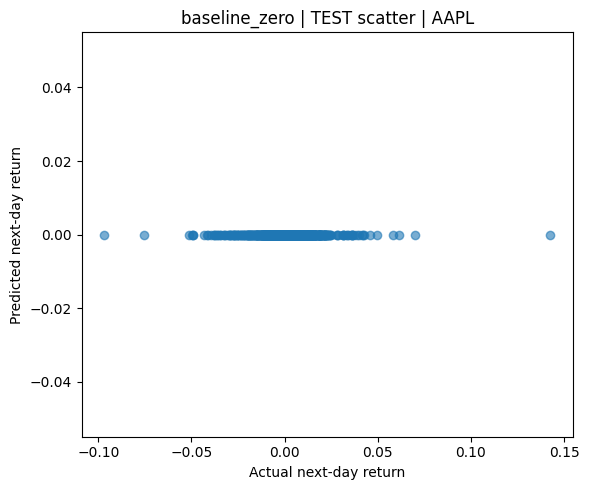

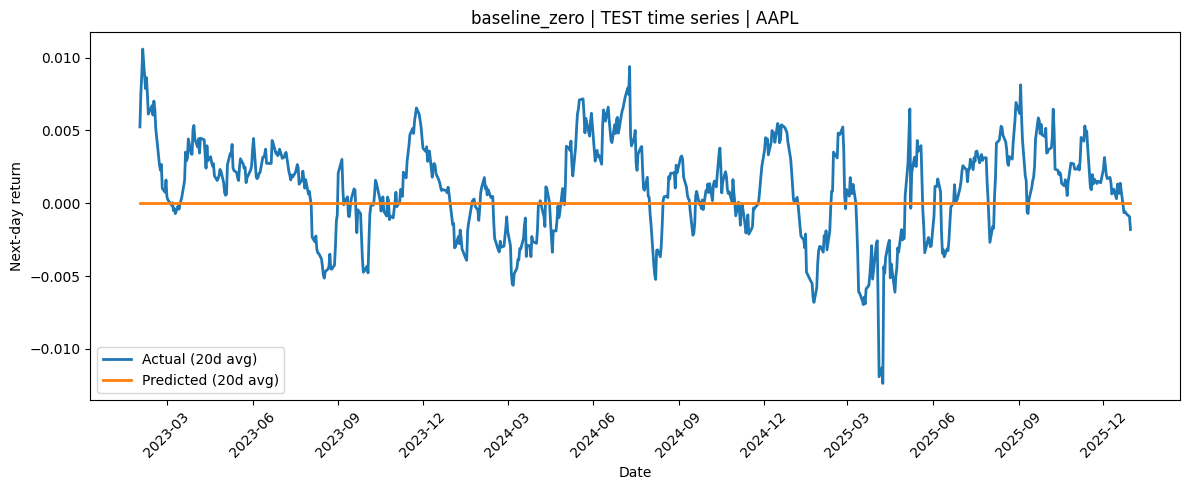

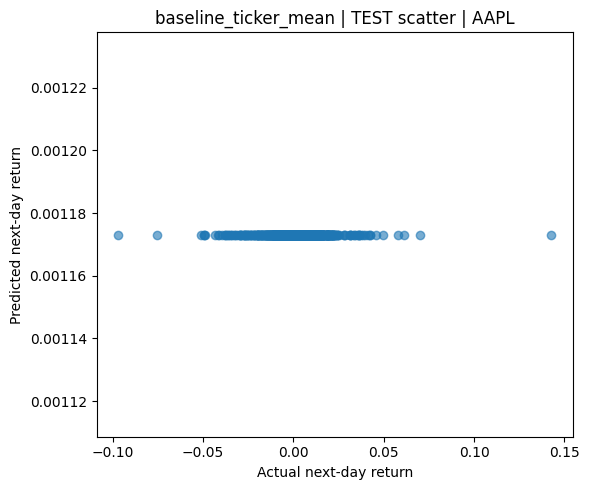

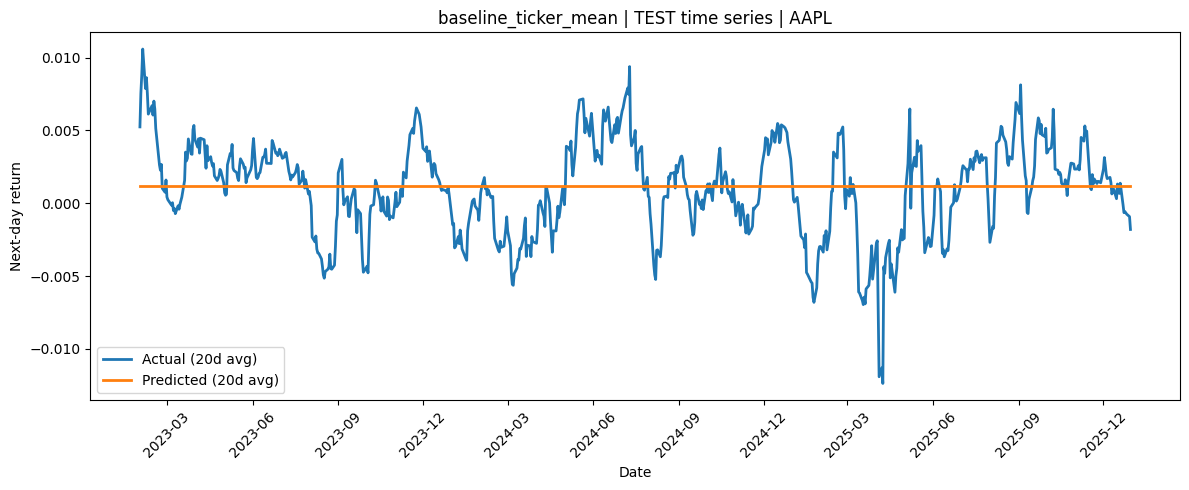

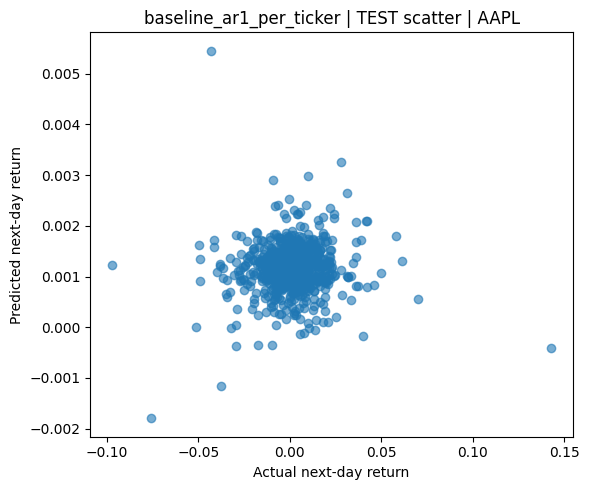

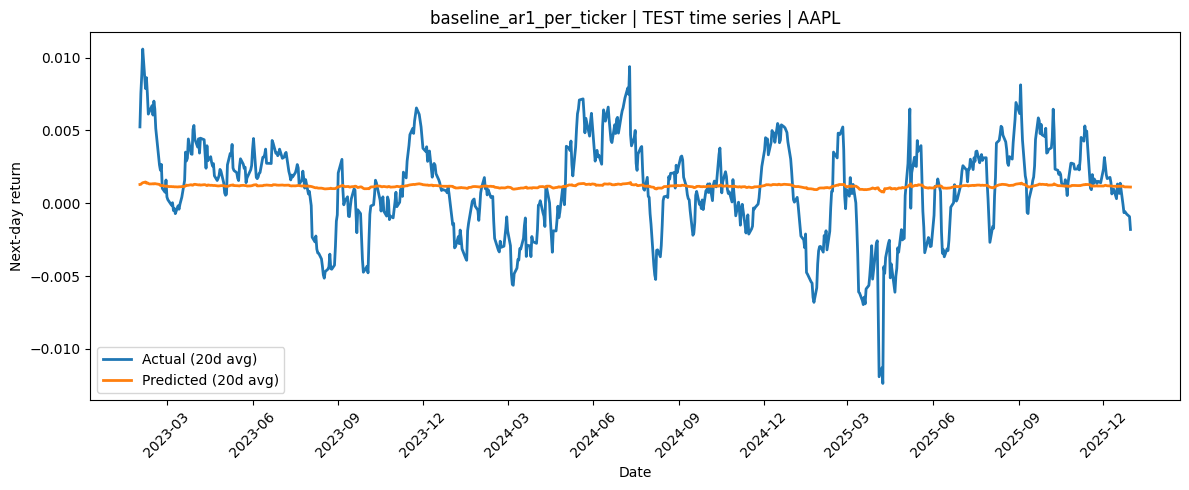

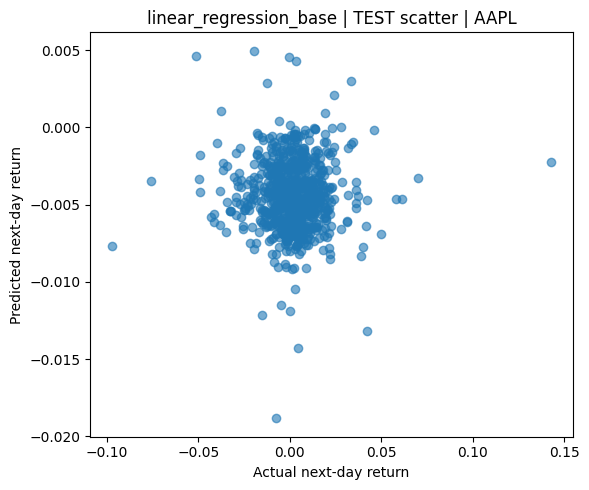

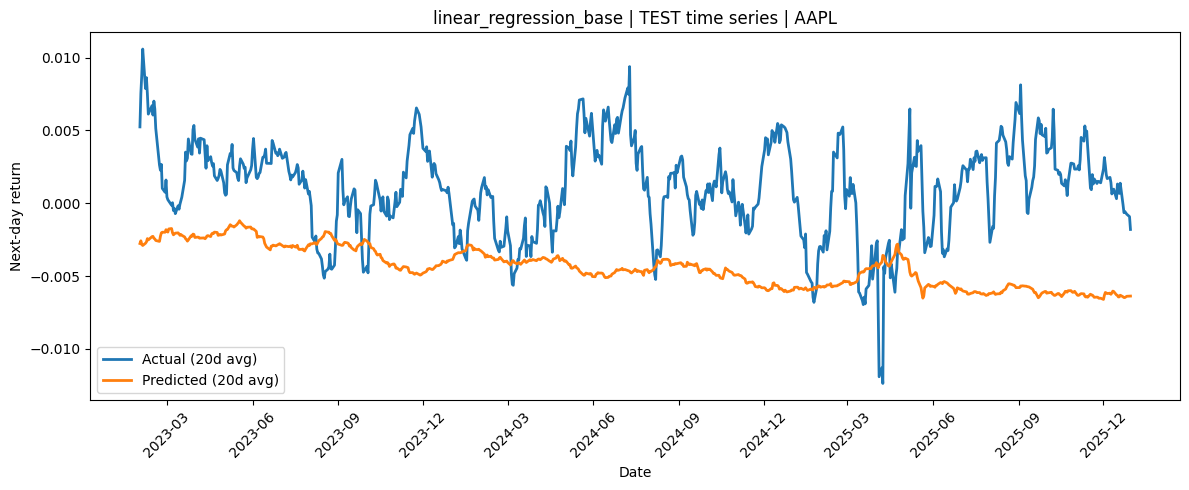

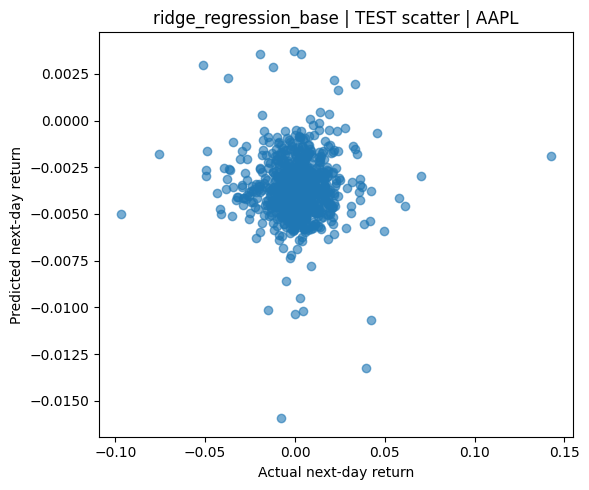

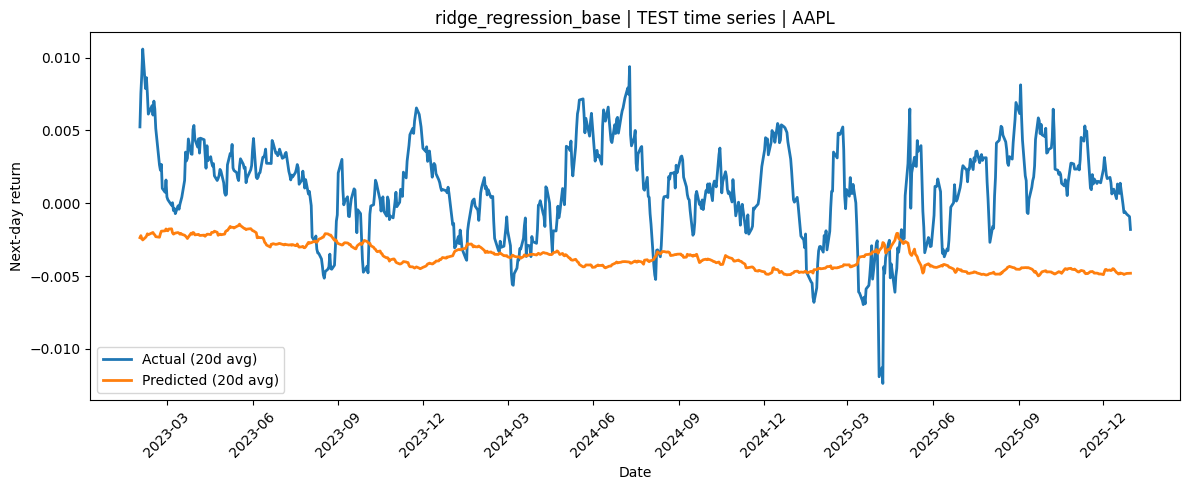

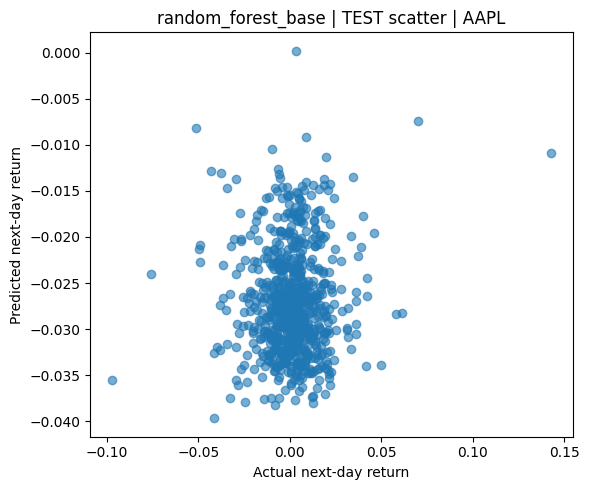

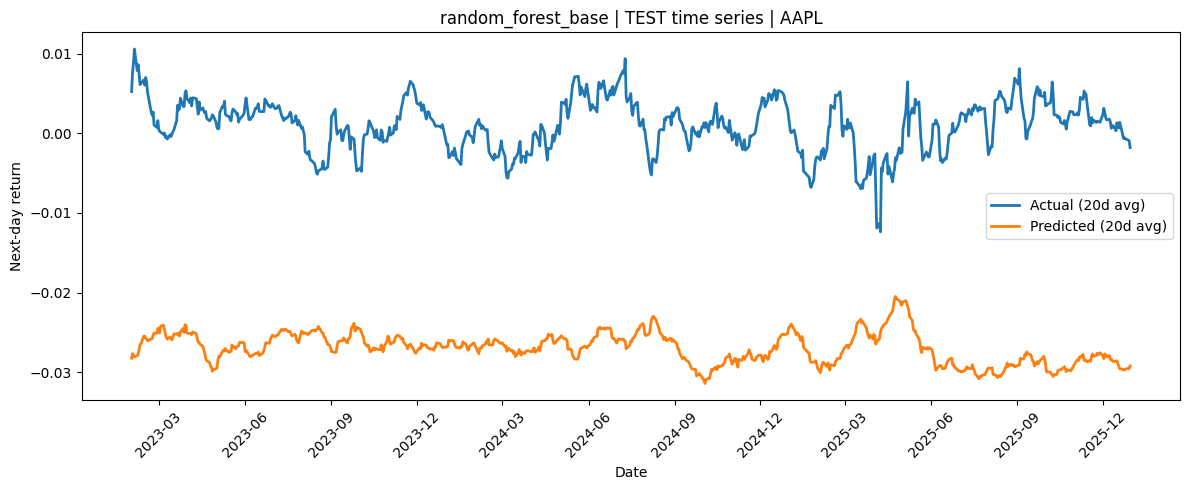


 Plotting TEST results for MSFT



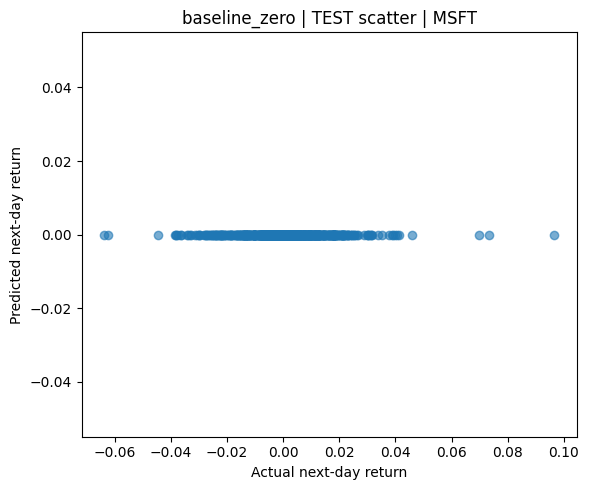

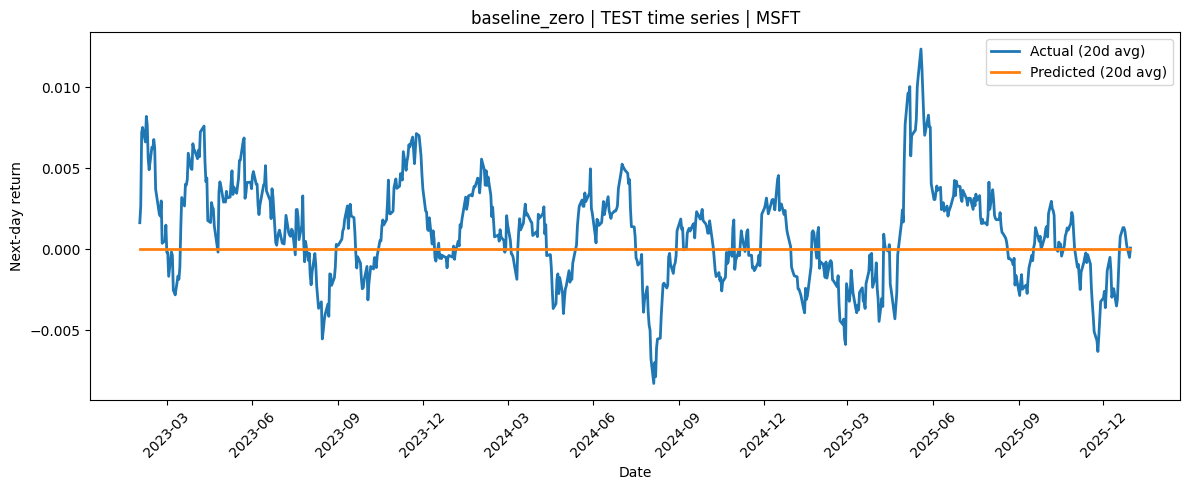

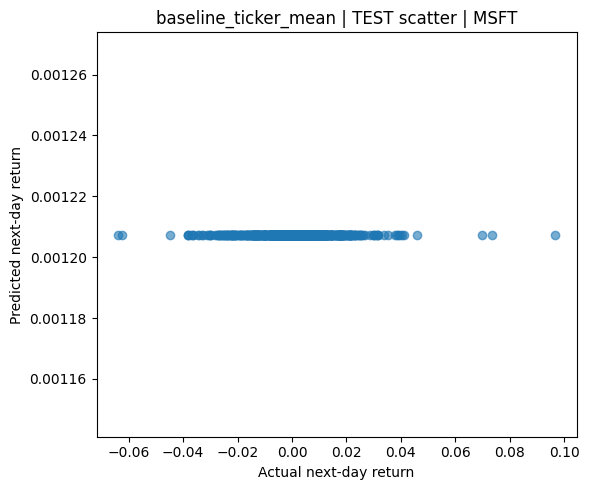

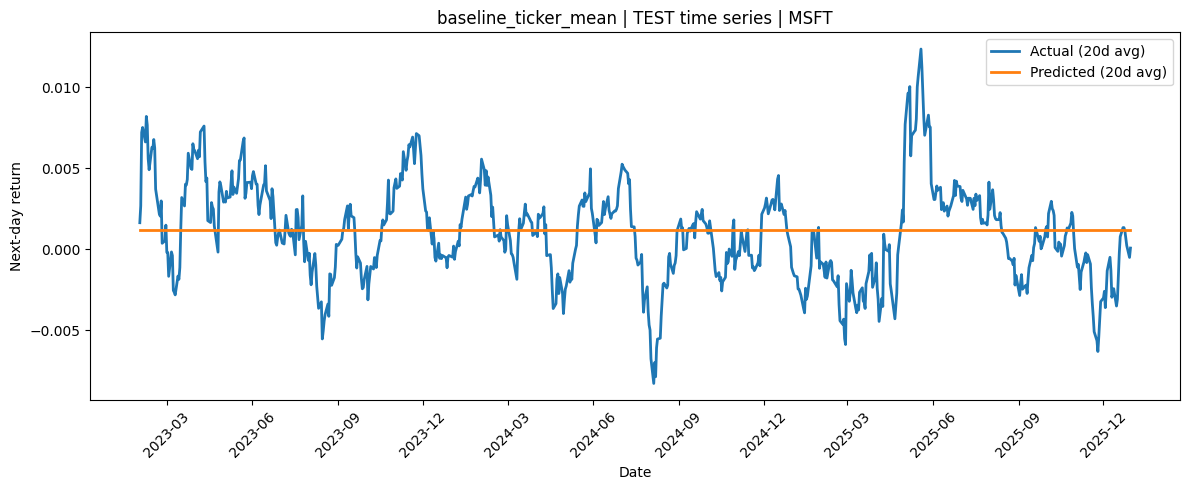

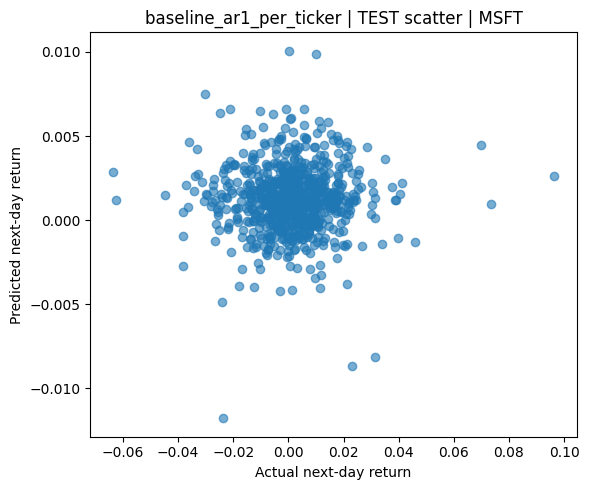

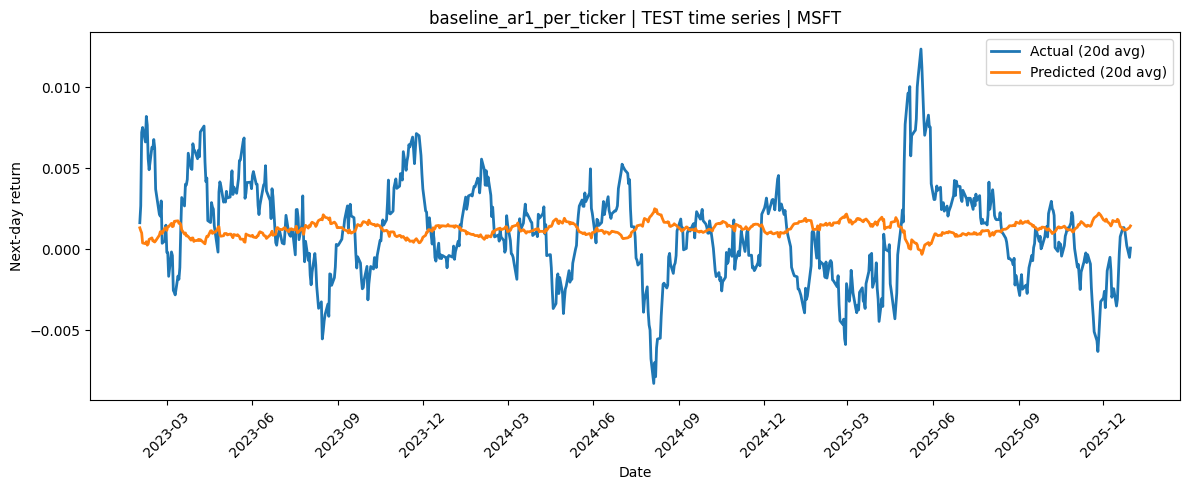

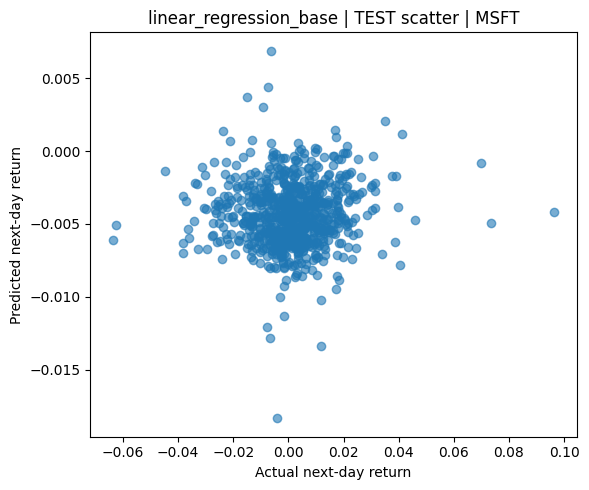

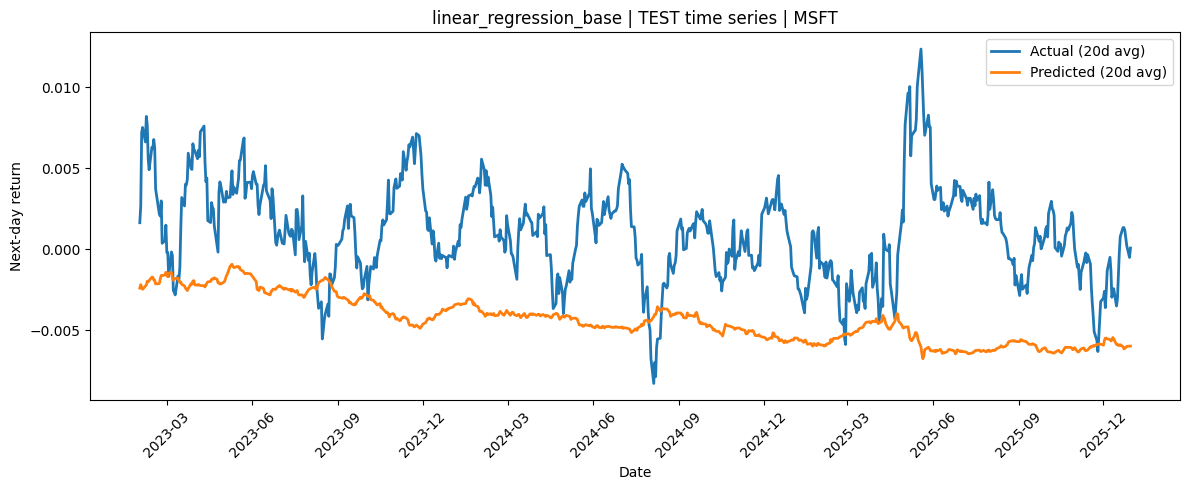

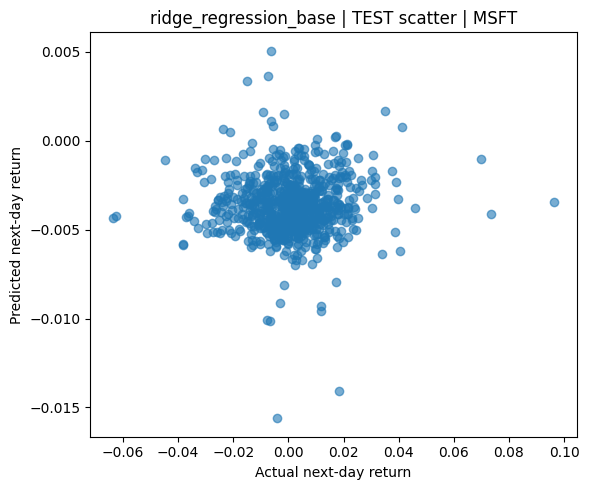

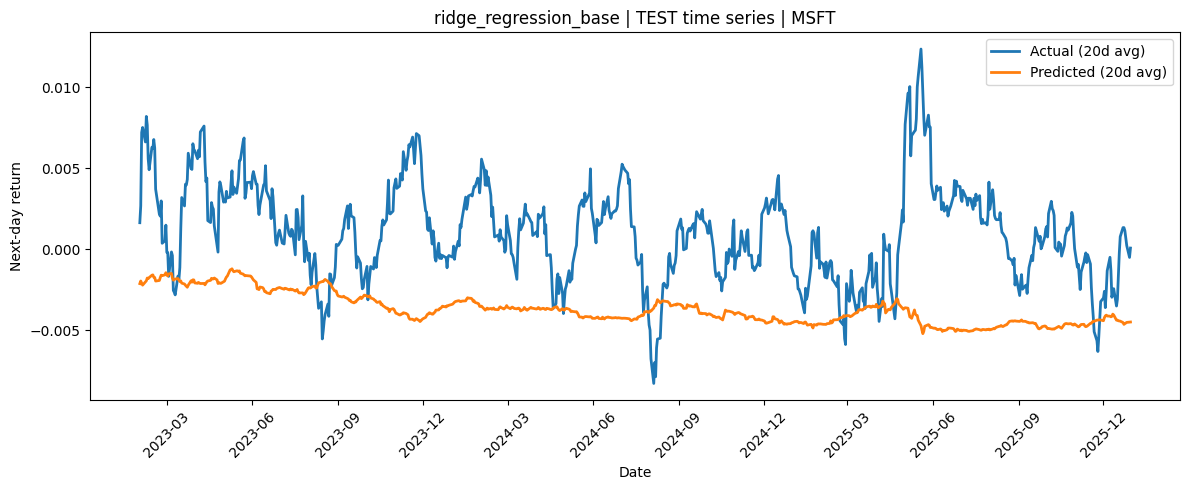

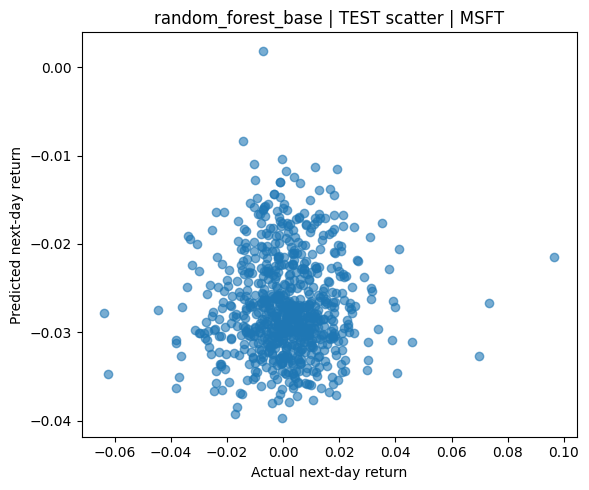

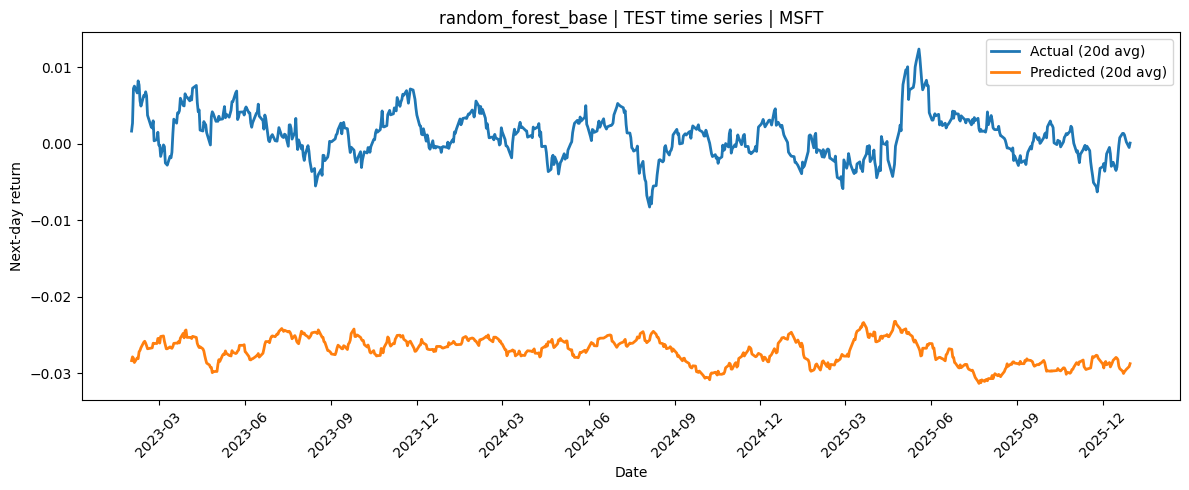


 Plotting TEST results for NVDA



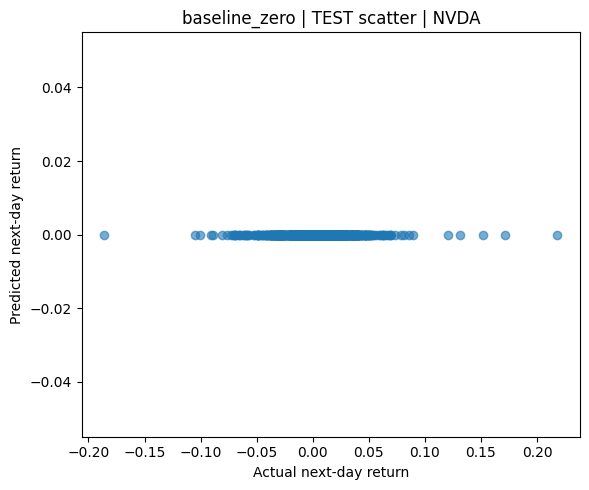

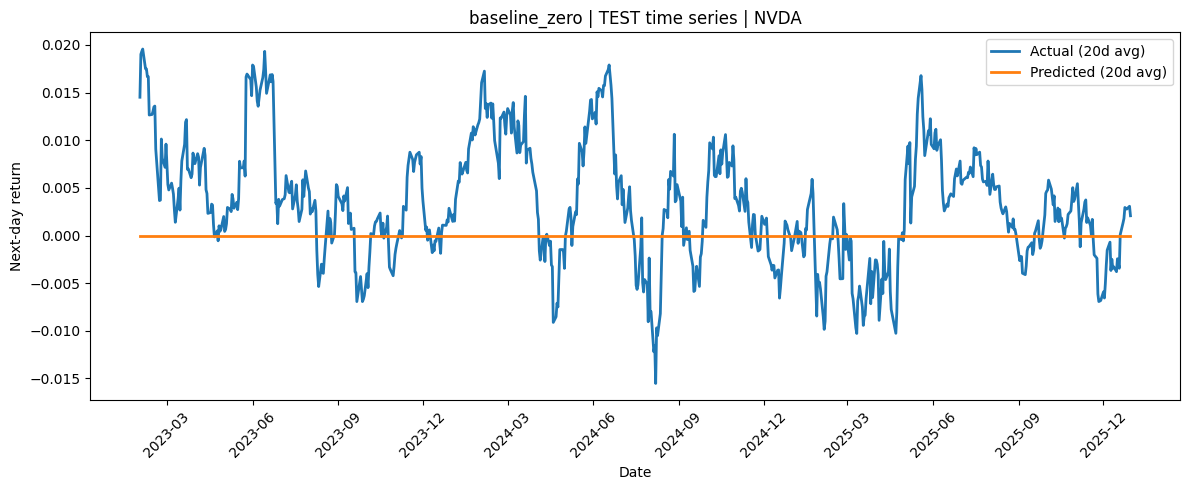

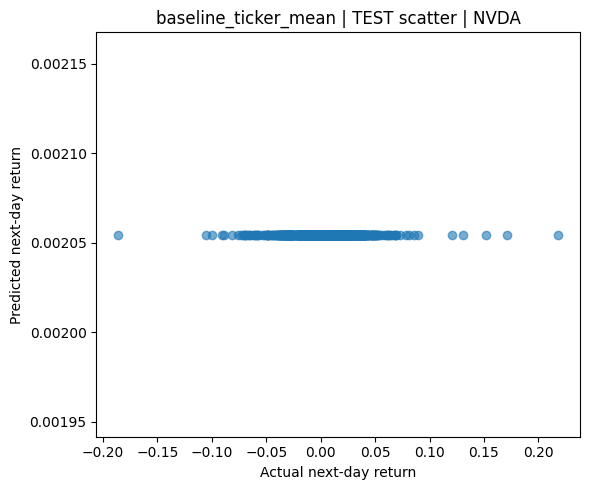

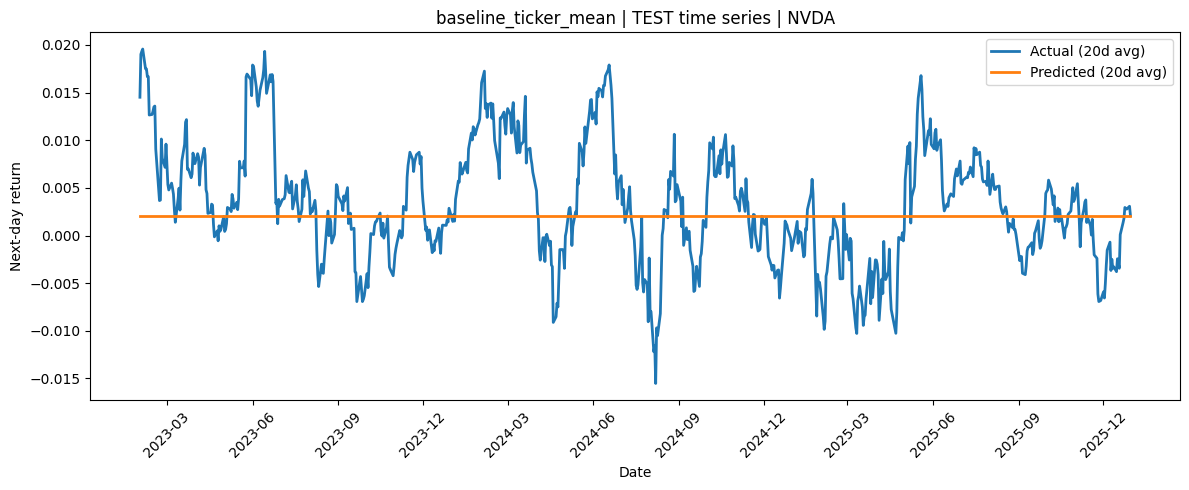

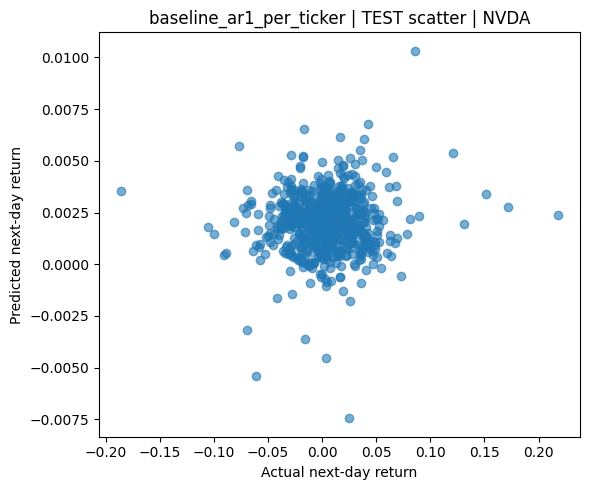

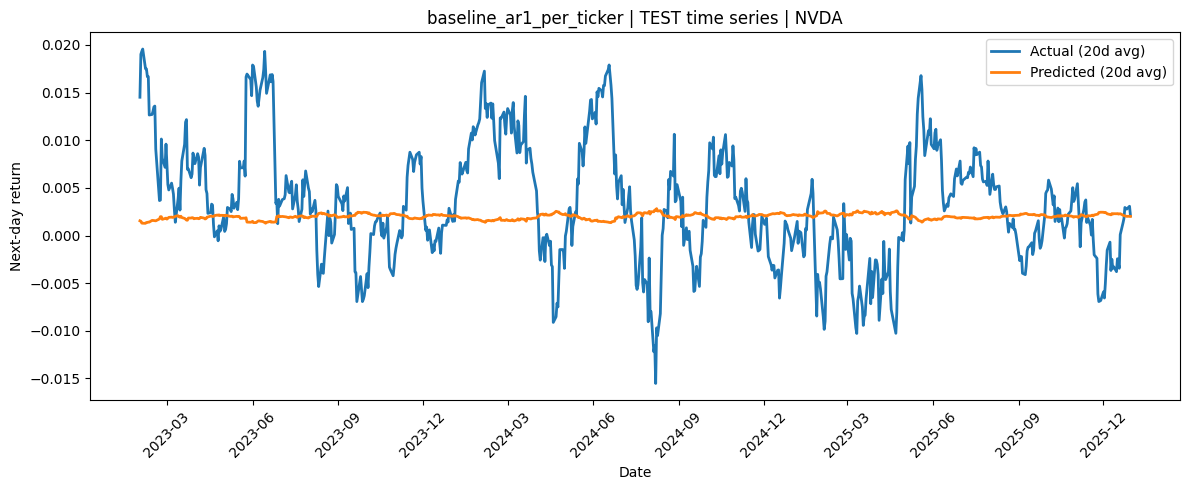

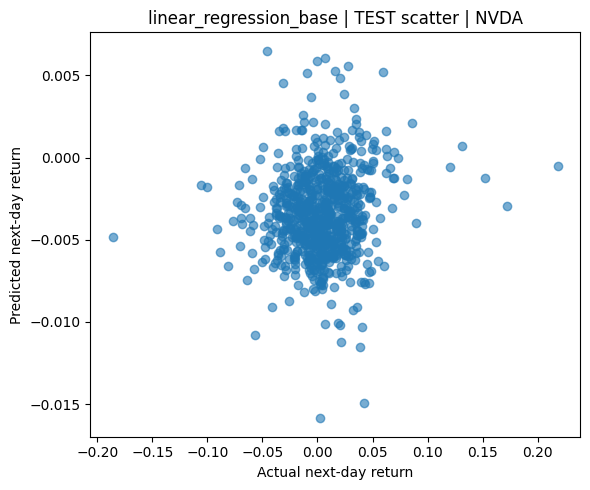

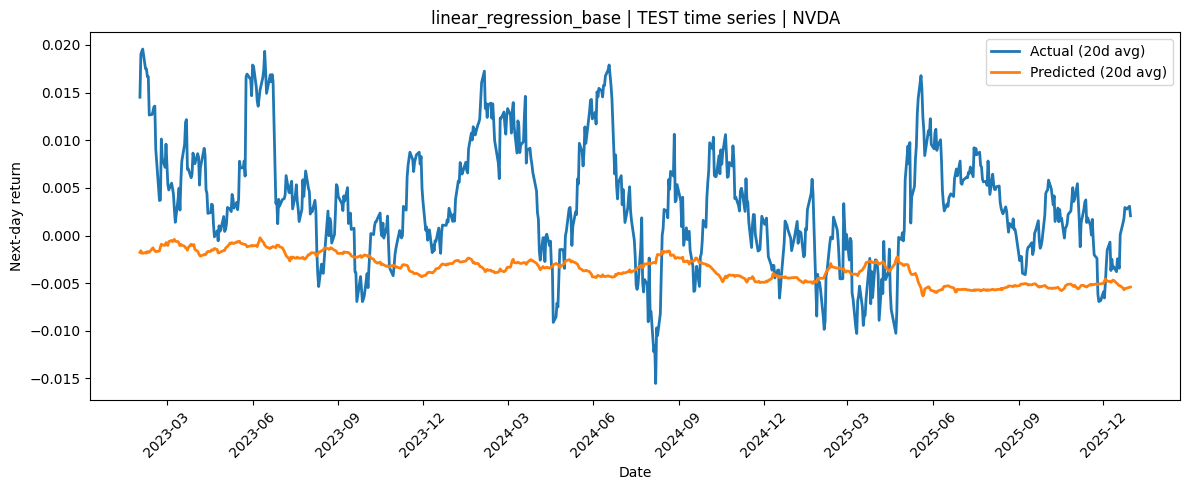

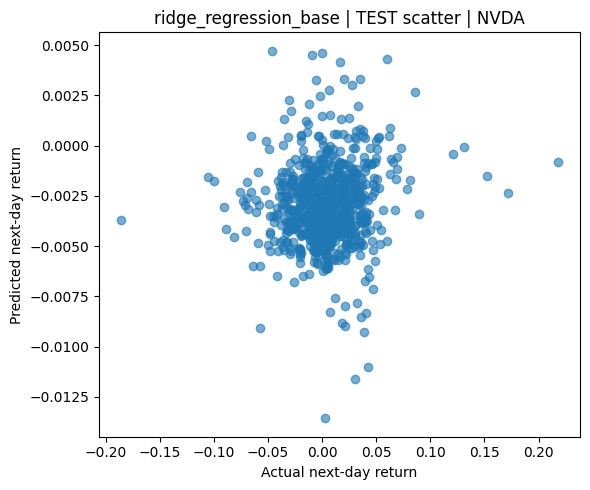

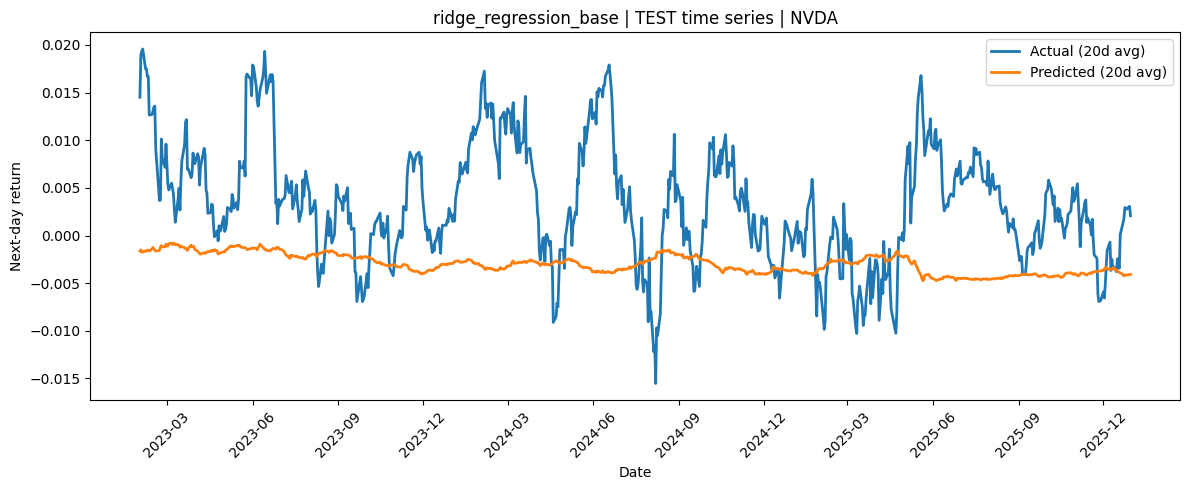

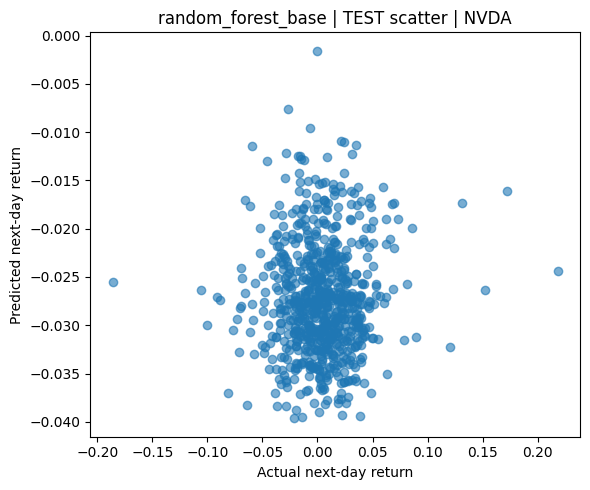

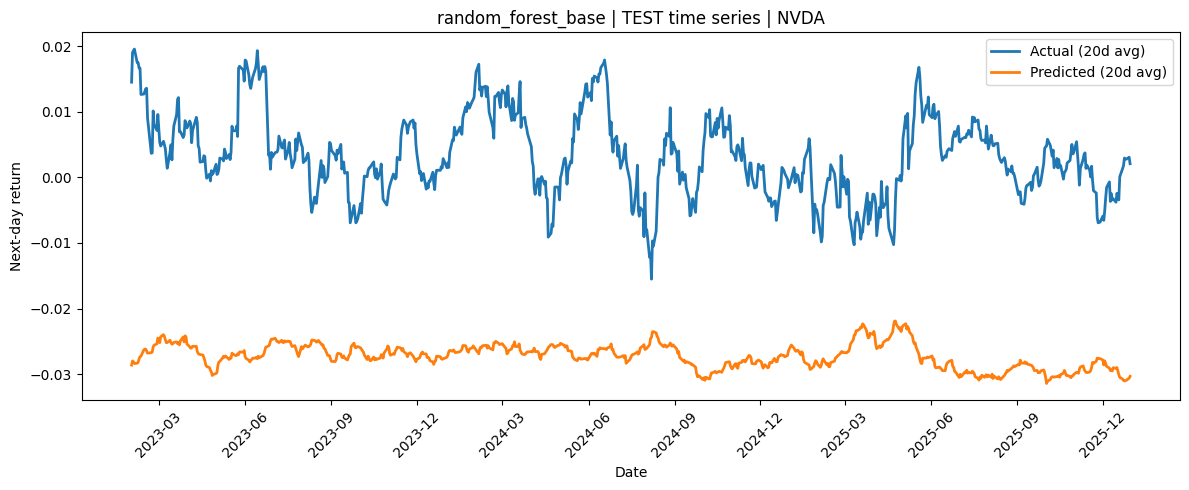

Saved plots to: /notebooks/stock_project/stock_project/reports/figures


In [34]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# ================================
# Load and display model metrics
# ================================
metrics_path = TAB_DIR / "model_metrics.csv"
metrics = pd.read_csv(metrics_path)
display(metrics.sort_values(["split", "RMSE_bps"]))

# ================================
# Choose tickers and models
# ================================
TICKERS_TO_PLOT = ["AAPL", "MSFT", "NVDA"]

models_to_plot = [
    "baseline_zero",
    "baseline_ticker_mean",
    "baseline_ar1_per_ticker",
    "linear_regression_base",
    "ridge_regression_base",
    "random_forest_base",
]

# ================================
# Plot loop
# ================================
for ticker in TICKERS_TO_PLOT:
    print(f"\n==============================")
    print(f" Plotting TEST results for {ticker}")
    print(f"==============================\n")

    for model_name in models_to_plot:

        pred_path = PRED_DIR / f"{model_name}.parquet"
        if not pred_path.exists():
            print("Missing predictions for:", model_name)
            continue

        p = pd.read_parquet(pred_path)

        p_test = (
            p[(p["split"] == "test") & (p["Ticker"] == ticker)]
            .sort_values("target_date")
            .copy()
        )

        if len(p_test) == 0:
            print(f"No test data for {ticker} in {model_name}")
            continue

        # ================================
        # 1) Scatter Plot
        # ================================
        fig, ax = plt.subplots(figsize=(6, 5))

        ax.scatter(
            p_test["y_true"],
            p_test["y_pred"],
            alpha=0.6
        )

        ax.set_title(f"{model_name} | TEST scatter | {ticker}")
        ax.set_xlabel("Actual next-day return")
        ax.set_ylabel("Predicted next-day return")

        plt.tight_layout()
        plt.savefig(FIG_DIR / f"{model_name}_scatter_test_{ticker}.png", dpi=300)
        plt.show()

        # ================================
        # 2) Time Series Plot (clean axis)
        # ================================
        fig, ax = plt.subplots(figsize=(12, 5))

        # Optional smoothing for publication clarity
        rolling_true = p_test["y_true"].rolling(20).mean()
        rolling_pred = p_test["y_pred"].rolling(20).mean()

        ax.plot(
            p_test["target_date"],
            rolling_true,
            label="Actual (20d avg)",
            linewidth=2
        )

        ax.plot(
            p_test["target_date"],
            rolling_pred,
            label="Predicted (20d avg)",
            linewidth=2
        )

        ax.set_title(f"{model_name} | TEST time series | {ticker}")
        ax.set_xlabel("Date")
        ax.set_ylabel("Next-day return")

        # Clean x-axis formatting
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
        plt.xticks(rotation=45)

        ax.legend()
        plt.tight_layout()

        plt.savefig(FIG_DIR / f"{model_name}_timeseries_test_{ticker}.png", dpi=300)
        plt.show()

print("Saved plots to:", FIG_DIR.resolve())

# Add GARCH sigma features (volatility forecasts)

Goal:
Measure whether adding GARCH-based volatility forecasts improves next-day return prediction.

Experimental design:
- Keep the model architecture fixed (Linear, Ridge, Random Forest).
- Keep the dataset, splits, target, and metrics identical.
- Only change the feature set:
  - Base features: lag returns + rolling vol + market/macro + ticker encoding
  - Base + GARCH: base features + (garch11_t_sigma1, gjr11_t_sigma1, egarch11_t_sigma1)

This is an ablation study:
It isolates the incremental value of volatility forecasts as features.

Outputs saved:
- Predictions vs actuals per model (train/val/test)
- Metrics table updated (`reports/tables/model_metrics.csv`)
- Interpretability artifacts:
  - Linear/Ridge coefficients
  - Random Forest feature importances

In [35]:
from sklearn.linear_model import LinearRegression

MODEL_NAME = "linear_regression_plus_garch_sigma"
NUM_FEATURES = num_features_plus_garch_sigma  # base + GARCH sigma features

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), NUM_FEATURES),
        ("cat", OneHotEncoder(handle_unknown="ignore"), ["Ticker"]),
    ],
    remainder="drop"
)

pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", LinearRegression()),
])

pipe.fit(train_df[NUM_FEATURES + ["Ticker"]], train_df[TARGET_COL])

pred_df = pd.concat([
    make_pred_frame(train_df, pipe.predict(train_df[NUM_FEATURES + ["Ticker"]]), MODEL_NAME),
    make_pred_frame(val_df,   pipe.predict(val_df[NUM_FEATURES + ["Ticker"]]),   MODEL_NAME),
    make_pred_frame(test_df,  pipe.predict(test_df[NUM_FEATURES + ["Ticker"]]),  MODEL_NAME),
], ignore_index=True)

metrics_df = evaluate_predictions(pred_df, MODEL_NAME, baseline_mse_by_split=BASELINE_MSE_BY_SPLIT)
display(metrics_df)

# Interpretability: coefficients
feat_names = pipe.named_steps["preprocess"].get_feature_names_out()
coefs = pipe.named_steps["model"].coef_
coef_df = pd.DataFrame({"feature": feat_names, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)

coef_path = TAB_DIR / f"{MODEL_NAME}_coefficients.csv"
coef_df.to_csv(coef_path, index=False)
print("Saved coefficients:", coef_path)

save_predictions_and_metrics(pred_df, metrics_df, MODEL_NAME)

,MAE,RMSE,MSE,MAE_bps,RMSE_bps,DirectionalAcc,Corr,model,split,n,OOS_R2_vs_baseline
0,0.012331,0.019079,0.000364,123.310374,190.787556,0.536788,0.103904,linear_regression_plus_garch_sigma,train,7720,0.010167
1,0.020030,0.029697,0.000882,200.304505,296.965015,0.512897,-0.043035,linear_regression_plus_garch_sigma,val,6048,-0.030323
2,0.017453,0.025486,0.000650,174.532262,254.861032,0.463382,0.050451,linear_regression_plus_garch_sigma,test,6008,-0.057701


Saved coefficients: stock_project/reports/tables/linear_regression_plus_garch_sigma_coefficients.csv
Saved predictions: stock_project/reports/predictions/linear_regression_plus_garch_sigma.parquet
Updated metrics table: stock_project/reports/tables/model_metrics.csv
